# Balancing the dataset at doc level

We know from prepare_extra_articles.ipynb that the new articles are a sensible addition, but that we have far too many positive ones.

In [35]:
# Set root path
path_to_root = '/work/PernilleHøjlundBrams#8577/NLP_2023_P'

# -- Load in data
import pandas as pd

MIT_ai_news = pd.read_csv(f"{path_to_root}/data/old/articles.csv", sep =";").drop(columns = ["Unnamed: 0"])
extra_articles = pd.read_csv(f"{path_to_root}/data/extra_articles/extra_articles_23dec.csv", sep = ",").drop(columns = ["Unnamed: 0",'comment'])

# Merge
articles_aug = pd.concat([MIT_ai_news, extra_articles]).drop_duplicates().reset_index().drop(columns = ['index'])
articles_aug['Article Body'] = articles_aug['Article Body'].str.strip('[]')
articles_aug['Article Body'] = articles_aug['Article Body'].str.strip("''")

# Remove special characters from Article Body col herhen
articles_aug.to_csv("articles_full_aug.csv")

In [9]:
# ----- FUNCTION FOR ABSA
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
from transformers import pipeline

# LOAD 1: (Aspect-Based Sentiment Analysis = ABSA) # 0 to 1, indicating level of confidence for each sentiment
absa_tokenizer = AutoTokenizer.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")
absa_model = AutoModelForSequenceClassification \
  .from_pretrained("yangheng/deberta-v3-base-absa-v1.1")

import torch
from torch.nn.functional import softmax

def run_absa_for_dataframe(df, aspects):
    for aspect in aspects:
        # Check if the columns already exist
        if not all(x in df.columns for x in [f'{aspect}_POS', f'{aspect}_NEU', f'{aspect}_NEG']):
            # Create a column for each aspect and sentiment if not exist
            df[f'{aspect}_POS'] = 0.0
            df[f'{aspect}_NEU'] = 0.0
            df[f'{aspect}_NEG'] = 0.0
            
            # Use iterrows() to iterate over DataFrame rows
            for index, row in df.iterrows():
                sentence = row['Article Body']
                if pd.isna(sentence):
                    continue  # Skip rows where 'body' is NaN

                # Tokenize and predict sentiment
                inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
                with torch.no_grad():  # Disable gradient calculation
                    outputs = absa_model(**inputs)

                # Calculate probabilities
                probs = softmax(outputs.logits, dim=1).numpy()[0]

                # Assign the probabilities to the correct columns
                df.at[index, f'{aspect}_NEG'] = probs[0]
                df.at[index, f'{aspect}_NEU'] = probs[1]
                df.at[index, f'{aspect}_POS'] = probs[2]
        else:
            print(f"Columns for aspect '{aspect}' already exist. Skipping ABSA for this aspect.")

    return df

# Run function
aspects = ['AI']

# --- DENSITY PLOTTING
import matplotlib.pyplot as plt
import seaborn as sns

def plot_density_distributions(pos_list, neg_list, neu_list):
    plt.figure(figsize=(10, 6))

    sns.kdeplot(pos_list, shade=True, color="g", label="Positive")
    sns.kdeplot(neg_list, shade=True, color="r", label="Negative")
    sns.kdeplot(neu_list, shade=True, color="b", label="Neutral")

    plt.title(f"Density Distribution of Sentiments: {aspect}, Augmented data, doc-level, pre-balancing")
    plt.xlabel("Sentiment Score")
    plt.ylabel("Density")
    plt.legend()

    plt.show()

# -- CATEGORICAL PLOT
def find_max_label_with_combined_conditions(row):
    # Check if both AI_POS and AI_NEG are below 0.5
    if row['AI_POS'] <= 0.5 and row['AI_NEG'] <= 0.5:
        # If they are also within 0.2 of each other, assign 'AI_NEU'
        if abs(row['AI_POS'] - row['AI_NEG']) <= 0.1:
            return 'AI_NEU'
        else:
            # Otherwise, use the highest score
            scores = {'AI_POS': row['AI_POS'], 'AI_NEU': row['AI_NEU'], 'AI_NEG': row['AI_NEG']}
            max_label = max(scores, key=scores.get)
            return max_label
    else:
        # If either is above 0.5, use the highest score
        scores = {'AI_POS': row['AI_POS'], 'AI_NEU': row['AI_NEU'], 'AI_NEG': row['AI_NEG']}
        max_label = max(scores, key=scores.get)
        return max_label


/work/PernilleHøjlundBrams#8577/venvs_new_exam/nlp-e23-exam_new/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Done with ABSA.


/tmp/ipykernel_1061707/1969279822.py:56: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pos_list, shade=True, color="g", label="Positive")
/tmp/ipykernel_1061707/1969279822.py:57: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neg_list, shade=True, color="r", label="Negative")
/tmp/ipykernel_1061707/1969279822.py:58: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neu_list, shade=True, color="b", label="Neutral")


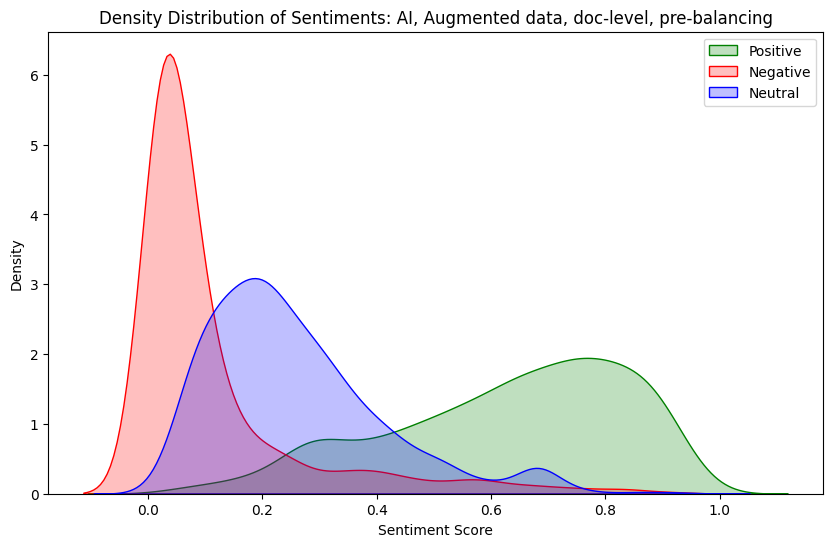

AI_label
AI_POS    896
AI_NEU    151
AI_NEG     76
Name: count, dtype: int64


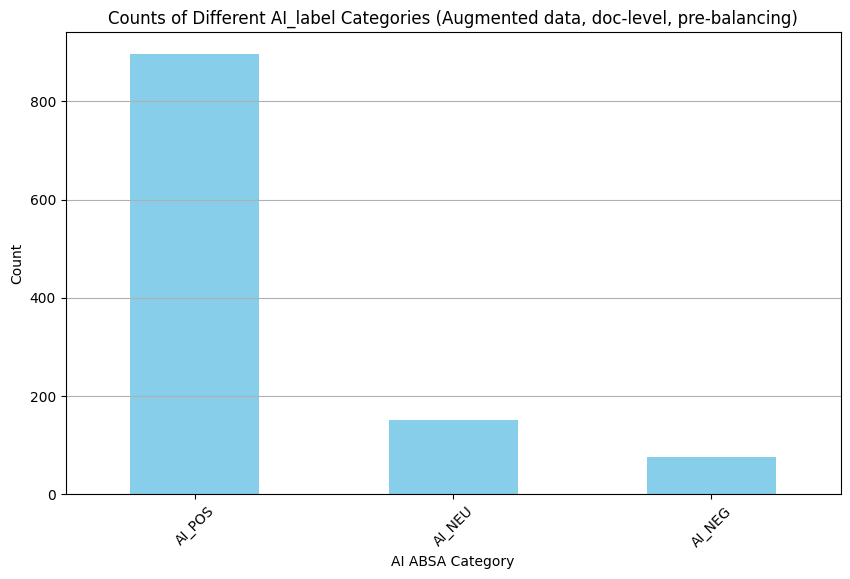

In [10]:
# -- Run ABSA
df_absa = run_absa_for_dataframe(articles_aug, aspects)
print("Done with ABSA.")

# Drop duplicates and other NA rows
df_absa = df_absa.drop_duplicates()
df_absa = df_absa.reset_index()

# -- DENSITY PLOT
for aspect in aspects:
    plot_density_distributions(pos_list = df_absa[f'{aspect}_POS'],
                               neg_list = df_absa[f'{aspect}_NEG'],
                               neu_list = df_absa[f'{aspect}_NEU'])

# -- COUNT PLOT
# Apply the function to each row to create the 'AI_label' column
df_absa['AI_label'] = df_absa.apply(find_max_label_with_combined_conditions, axis=1)

# Count the occurrences of each category
category_counts_absaai = df_absa['AI_label'].value_counts()

# Print the counts
print(category_counts_absaai)

# Plotting
plt.figure(figsize=(10, 6))
category_counts_absaai.plot(kind='bar', color='skyblue')
plt.title('Counts of Different AI_label Categories (Augmented data, doc-level, pre-balancing)')
plt.xlabel('AI ABSA Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

#df_absa.to_csv(f"{path_to_root}/data/prelim_dataframes/df_aug_absa.csv")

## Topic modelling

In [19]:
df_absa['Article Body'] = df_absa['Article Body'].astype(str)
df_absa

index     Published Date                Author  \
0         0       July 7, 2023             Adam Zewe   
1         1       July 6, 2023           Alex Ouyang   
2         2      June 30, 2023  Jennifer Michalowski   
3         3      June 30, 2023   Mary Beth Gallagher   
4         4      June 30, 2023             Adam Zewe   
...     ...                ...                   ...   
1118   1118     april 22, 2021          Miriam Vogel   
1119   1119       july 7, 2021         Natasha Lomas   
1120   1120  december 14, 2023    Darrel Etherington   
1121   1121  december 14, 2023          Kyle Wiggers   
1122   1122     march 16, 2021      Ismael Al-Amoudi   

                                                 Source  \
0                                       MIT News Office   
1     Abdul Latif Jameel Clinic for Machine Learning...   
2                 McGovern Institute for Brain Research   
3                                 School of Engineering   
4                                       MIT News Office   
...                                                 ...   
1118                                         Techcrunch   
1119                                         Techcrunch   
1120                                         Techcrunch   
1121                                         Techcrunch   
1122                                   The conversation   

                                         Article Header  \
0     Learning the language of molecules to predict ...   
1     MIT scientists build a system that can generat...   
2     When computer vision works more like a brain, ...   
3     Educating national security leaders on artific...   
4     Researchers teach an AI to write better chart ...   
...                                                 ...   
1118  To ensure inclusivity, the Biden administratio...   
1119  YouTube’s recommender AI still a horror show, ...   
1120  AI isn’t and won’t soon be evil or even smart,...   
1121  Distributional wants to develop software to re...   
1122  Artificial intelligence and algorithmic irresp...   

                                           Sub_Headings  \
0     This AI system only needs a small amount of da...   
1     BioAutoMATED, an open-source, automated machin...   
2     Training artificial neural networks with data ...   
3     Experts from MIT’s School of Engineering, Schw...   
4     A new dataset can help scientists develop auto...   
...                                                 ...   
1118                                                NaN   
1119                                                NaN   
1120                                                NaN   
1121                                                NaN   
1122                                                NaN   

                                           Article Body  \
0     Discovering new materials and drugs typically ...   
1     Is it possible to build machine-learning model...   
2     From cameras to self-driving cars, many of tod...   
3     Understanding artificial intelligence and how ...   
4     Chart captions that explain complex trends and...   
...                                                 ...   
1118  The National Security Commission on Artificial...   
1119  For years YouTube’s video-recommending algorit...   
1120  Artificial intelligence — or rather, the varie...   
1121  Companies are increasingly curious about AI an...   
1122  The classic 1995 crime film The Usual Suspects...   

                                                    Url    AI_POS    AI_NEU  \
0     https://news.mit.edu/2023/learning-language-mo...  0.800703  0.111229   
1     https://news.mit.edu/2023/bioautomated-open-so...  0.513258  0.411124   
2     https://news.mit.edu/2023/when-computer-vision...  0.653135  0.227004   
3     https://news.mit.edu/2023/educating-national-s...  0.761534  0.227785   
4     https://news.mit.edu/2023/researchers-chart-ca...  0.911656  0.070210   
...                    

In [26]:
df_absa['Article Body'] = df_absa['Article Body'].fillna('')
df_absa

index     Published Date                Author  \
0         0       July 7, 2023             Adam Zewe   
1         1       July 6, 2023           Alex Ouyang   
2         2      June 30, 2023  Jennifer Michalowski   
3         3      June 30, 2023   Mary Beth Gallagher   
4         4      June 30, 2023             Adam Zewe   
...     ...                ...                   ...   
1118   1118     april 22, 2021          Miriam Vogel   
1119   1119       july 7, 2021         Natasha Lomas   
1120   1120  december 14, 2023    Darrel Etherington   
1121   1121  december 14, 2023          Kyle Wiggers   
1122   1122     march 16, 2021      Ismael Al-Amoudi   

                                                 Source  \
0                                       MIT News Office   
1     Abdul Latif Jameel Clinic for Machine Learning...   
2                 McGovern Institute for Brain Research   
3                                 School of Engineering   
4                                       MIT News Office   
...                                                 ...   
1118                                         Techcrunch   
1119                                         Techcrunch   
1120                                         Techcrunch   
1121                                         Techcrunch   
1122                                   The conversation   

                                         Article Header  \
0     Learning the language of molecules to predict ...   
1     MIT scientists build a system that can generat...   
2     When computer vision works more like a brain, ...   
3     Educating national security leaders on artific...   
4     Researchers teach an AI to write better chart ...   
...                                                 ...   
1118  To ensure inclusivity, the Biden administratio...   
1119  YouTube’s recommender AI still a horror show, ...   
1120  AI isn’t and won’t soon be evil or even smart,...   
1121  Distributional wants to develop software to re...   
1122  Artificial intelligence and algorithmic irresp...   

                                           Sub_Headings  \
0     This AI system only needs a small amount of da...   
1     BioAutoMATED, an open-source, automated machin...   
2     Training artificial neural networks with data ...   
3     Experts from MIT’s School of Engineering, Schw...   
4     A new dataset can help scientists develop auto...   
...                                                 ...   
1118                                                NaN   
1119                                                NaN   
1120                                                NaN   
1121                                                NaN   
1122                                                NaN   

                                           Article Body  \
0     Discovering new materials and drugs typically ...   
1     Is it possible to build machine-learning model...   
2     From cameras to self-driving cars, many of tod...   
3     Understanding artificial intelligence and how ...   
4     Chart captions that explain complex trends and...   
...                                                 ...   
1118  The National Security Commission on Artificial...   
1119  For years YouTube’s video-recommending algorit...   
1120  Artificial intelligence — or rather, the varie...   
1121  Companies are increasingly curious about AI an...   
1122  The classic 1995 crime film The Usual Suspects...   

                                                    Url    AI_POS    AI_NEU  \
0     https://news.mit.edu/2023/learning-language-mo...  0.800703  0.111229   
1     https://news.mit.edu/2023/bioautomated-open-so...  0.513258  0.411124   
2     https://news.mit.edu/2023/when-computer-vision...  0.653135  0.227004   
3     https://news.mit.edu/2023/educating-national-s...  0.761534  0.227785   
4     https://news.mit.edu/2023/researchers-chart-ca...  0.911656  0.070210   
...                    

In [ ]:
# --- Check optimal number of topics
from gensim import corpora
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd
import string
import nltk
import numpy as np
from gensim.models.coherencemodel import CoherenceModel

np.random.seed(38)  # For reproducibility

# Dataframe 'nodes_absa_downsampled' ready
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

custom_stopwords = ['say', 'says', 'said', 'also', 'one', 'two', 'three', 'mit', 'the', '—','ai','make','may','could','like','would','use''videgaray']
stop_words = set(stopwords.words('english')).union(custom_stopwords)
lemma = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    return [lemma.lemmatize(word) for word in tokens if word not in stop_words and word.isalnum()]

# Preprocess the texts
texts = df_absa['Article Body'].apply(preprocess_text)

# Create Dictionary and Corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Find Optimal Number of Topics
coherence_values = []
for num_topics in range(5, 50, 2): # Training models set to start at 5, increase with stepsize 5
    model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10)
    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

# Get the optimal number of topics
max_coherence_val = max(coherence_values)
optimal_k = (coherence_values.index(max_coherence_val) + 1) * 5
print("Optimal number of topics:", optimal_k)

In [ ]:
# --- RUN TOPIC MODELLING
# function needed
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd
import string
import nltk

def run_topic_modeling(dataframe, text_column, num_topics=30, num_words=10):
    nltk.download('stopwords')
    nltk.download('wordnet')

    custom_stopwords = ['say', 'says', 'said', 'also', 'one', 'two', 'three', 'mit', 'the', '—','ai','make','may','could','like','would','use''videgaray']
    stop_words = set(stopwords.words('english')).union(custom_stopwords)
    exclude = set(string.punctuation)
    lemma = WordNetLemmatizer()

    def preprocess_text(text):
        tokens = word_tokenize(text.lower())
        tokens = [lemma.lemmatize(word) for word in tokens if word not in stop_words and word.isalnum()]
        return tokens

    texts = dataframe[text_column].apply(preprocess_text)
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)
    dataframe['main_topic'] = [sorted(lda_model[corpus[i]], key=lambda x: x[1], reverse=True)[0][0] for i in range(len(dataframe))]

    top_words_per_topic = lda_model.print_topics(num_topics=num_topics, num_words=num_words)
    for topic in top_words_per_topic:
        print(topic)

    return dataframe, lda_model

df_absa, lda_model = run_topic_modeling(df_absa, 'Article Body', num_topics=30, num_words=10)


In [ ]:
# -- PLOT POST BALANCING

# --- DENSITY PLOTTING (new title)
import matplotlib.pyplot as plt
import seaborn as sns

def plot_density_distributions(pos_list, neg_list, neu_list):
    plt.figure(figsize=(10, 6))

    sns.kdeplot(pos_list, shade=True, color="g", label="Positive")
    sns.kdeplot(neg_list, shade=True, color="r", label="Negative")
    sns.kdeplot(neu_list, shade=True, color="b", label="Neutral")

    plt.title(f"Density Distribution of Sentiments: {aspect}, Augmented data, doc-level, post-balancing")
    plt.xlabel("Sentiment Score")
    plt.ylabel("Density")
    plt.legend()

    plt.show()

# Drop duplicates and other NA rows
df_absa_downsampled = df_absa_downsampled.drop_duplicates()
df_absa_downsampled = df_absa_downsampled.reset_index()

# -- DENSITY PLOT
for aspect in aspects:
    plot_density_distributions(pos_list = df_absa_downsampled[f'{aspect}_POS'],
                               neg_list = df_absa_downsampled[f'{aspect}_NEG'],
                               neu_list = df_absa_downsampled[f'{aspect}_NEU'])

# -- COUNT PLOT
# Apply the function to each row to create the 'AI_label' column
#df_absa_downsampled['AI_label'] = df_absa_downsampled.apply(find_max_label_with_combined_conditions, axis=1)

# Count the occurrences of each category
category_counts_absaai = df_absa_downsampled['AI_label'].value_counts()

# Print the counts
print(category_counts_absaai)

# Plotting
plt.figure(figsize=(10, 6))
category_counts_absaai.plot(kind='bar', color='skyblue')
plt.title('Counts of Different AI_label Categories (Augmented data, doc-level, post-balancing)')
plt.xlabel('AI ABSA Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


# FORMER NOTES

/work/PernilleHøjlundBrams#8577/venvs_new_exam/nlp-e23-exam_new/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Done with ABSA.


/tmp/ipykernel_863536/995480517.py:57: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pos_list, shade=True, color="g", label="Positive")
/tmp/ipykernel_863536/995480517.py:58: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neg_list, shade=True, color="r", label="Negative")
/tmp/ipykernel_863536/995480517.py:59: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neu_list, shade=True, color="b", label="Neutral")


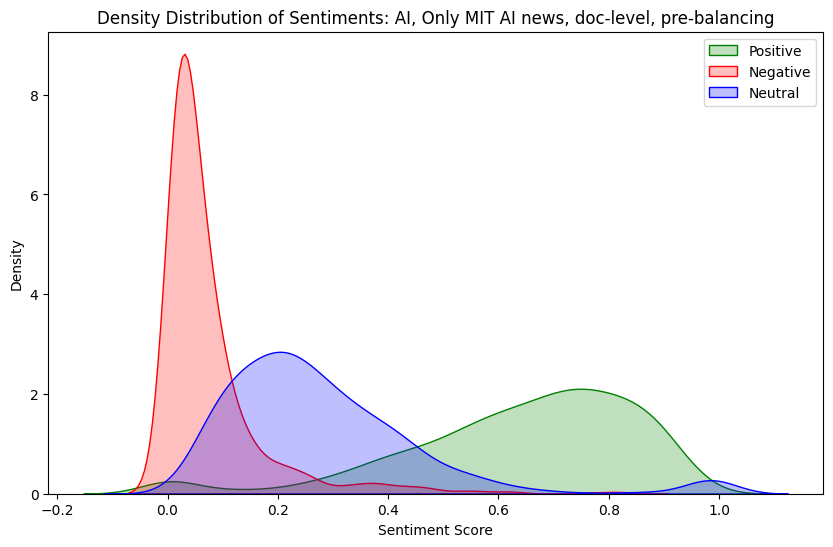

In [31]:
# For kicks - running ABSA on just the MIT AI news 
import pandas as pd
MIT_ai_news = pd.read_csv(f"{path_to_root}/data/old/articles.csv", sep =";").drop(columns = ["Unnamed: 0"])
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
from transformers import pipeline

# LOAD 1: (Aspect-Based Sentiment Analysis = ABSA) # 0 to 1, indicating level of confidence for each sentiment
absa_tokenizer = AutoTokenizer.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")
absa_model = AutoModelForSequenceClassification \
  .from_pretrained("yangheng/deberta-v3-base-absa-v1.1")

# ----- Get scores on for aspects
import torch
from torch.nn.functional import softmax

def run_absa_for_dataframe(df, aspects):
    for aspect in aspects:
        # Check if the columns already exist
        if not all(x in df.columns for x in [f'{aspect}_POS', f'{aspect}_NEU', f'{aspect}_NEG']):
            # Create a column for each aspect and sentiment if not exist
            df[f'{aspect}_POS'] = 0.0
            df[f'{aspect}_NEU'] = 0.0
            df[f'{aspect}_NEG'] = 0.0
            
            for idx, sentence in enumerate(df['Article Body']):
                # Tokenize and predict sentiment
                inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
                with torch.no_grad():  # Disable gradient calculation
                    outputs = absa_model(**inputs)

                # Calculate probabilities
                probs = softmax(outputs.logits, dim=1).numpy()[0]

                # Assign the probabilities to the correct columns
                df.loc[idx, f'{aspect}_NEG'] = probs[0]
                df.loc[idx, f'{aspect}_NEU'] = probs[1]
                df.loc[idx, f'{aspect}_POS'] = probs[2]
        else:
            print(f"Columns for aspect '{aspect}' already exist. Skipping ABSA for this aspect.")

    return df

# Run function
aspects = ['AI']
           
MIT_ai_news = run_absa_for_dataframe(MIT_ai_news, aspects)
print("Done with ABSA.")

# Plot - see balance prior to balancing on doc level
import matplotlib.pyplot as plt
import seaborn as sns

def plot_density_distributions(pos_list, neg_list, neu_list):
    plt.figure(figsize=(10, 6))

    sns.kdeplot(pos_list, shade=True, color="g", label="Positive")
    sns.kdeplot(neg_list, shade=True, color="r", label="Negative")
    sns.kdeplot(neu_list, shade=True, color="b", label="Neutral")

    plt.title(f"Density Distribution of Sentiments: {aspect}, Only MIT AI news, doc-level, pre-balancing")
    plt.xlabel("Sentiment Score")
    plt.ylabel("Density")
    plt.legend()

    plt.show()

for aspect in aspects:
    plot_density_distributions(pos_list = MIT_ai_news[f'{aspect}_POS'],
                               neg_list = MIT_ai_news[f'{aspect}_NEG'],
                               neu_list = MIT_ai_news[f'{aspect}_NEU'])  

AI_label
AI_POS    849
AI_NEU    151
AI_NEG     18
Name: count, dtype: int64


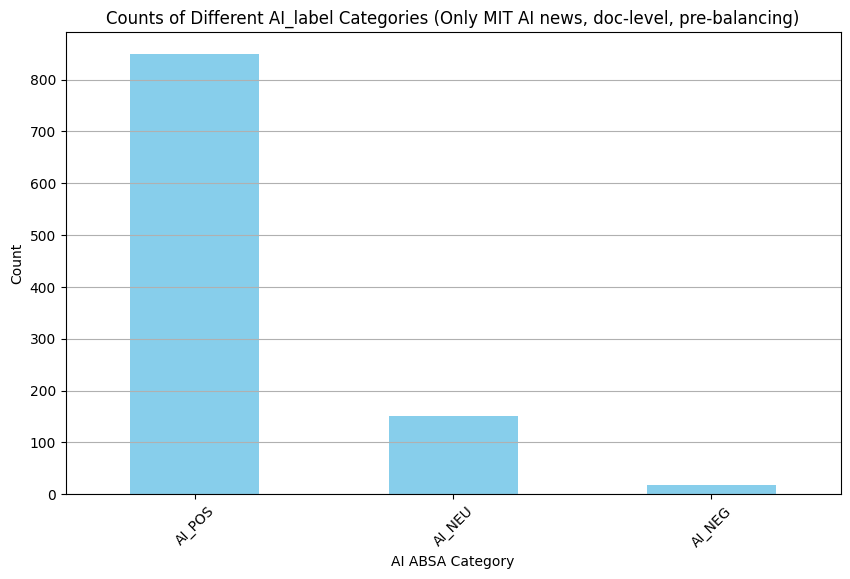

In [32]:
# Function to find the column with the maximum score
def find_max_label(row):
    # Extracting the scores for 'AI' from the row
    scores = {'AI_POS': row['AI_POS'], 'AI_NEU': row['AI_NEU'], 'AI_NEG': row['AI_NEG']}
    # Finding the key with the maximum score
    max_label = max(scores, key=scores.get)
    return max_label

# # FUNC2: Adjust the function to include the new condition for AI_NEU
# def find_max_label_with_neutral_condition(row):
#     # Check if both AI_POS and AI_NEG are between 0.5 and 0.5
#     if 0 <= row['AI_POS'] <= 0.50 and 0 <= row['AI_NEG'] <= 0.50:
#         return 'AI_NEU'
#     else:
#         scores = {'AI_POS': row['AI_POS'], 'AI_NEU': row['AI_NEU'], 'AI_NEG': row['AI_NEG']}
#         max_label = max(scores, key=scores.get)
#         return max_label

def reassign_to_neutral_if_close(row):
    # row already has an initial label assigned
    pos_score = row['AI_POS']
    neg_score = row['AI_NEG']
    
    # Check if the positive and negative scores are within 0.2 of each other
    if abs(pos_score - neg_score) <= 0.1:

        # if they're close return AI_NEU
        return 'AI_NEU'
    else:
        # Return the original label if the scores are not that close
        return row['AI_label']  

def find_max_label_with_combined_conditions(row):
    # Check if both AI_POS and AI_NEG are below 0.5
    if row['AI_POS'] <= 0.5 and row['AI_NEG'] <= 0.5:
        # If they are also within 0.2 of each other, assign 'AI_NEU'
        if abs(row['AI_POS'] - row['AI_NEG']) <= 0.15:
            return 'AI_NEU'
        else:
            # Otherwise, use the highest score
            scores = {'AI_POS': row['AI_POS'], 'AI_NEU': row['AI_NEU'], 'AI_NEG': row['AI_NEG']}
            max_label = max(scores, key=scores.get)
            return max_label
    else:
        # If either is above 0.5, use the highest score
        scores = {'AI_POS': row['AI_POS'], 'AI_NEU': row['AI_NEU'], 'AI_NEG': row['AI_NEG']}
        max_label = max(scores, key=scores.get)
        return max_label

# Apply the function to each row to create the 'AI_label' column
#MIT_ai_news['AI_label'] = MIT_ai_news.apply(find_max_label, axis=1)
#MIT_ai_news['AI_label'] = MIT_ai_news.apply(reassign_to_neutral_if_close, axis=1)
MIT_ai_news['AI_label'] = MIT_ai_news.apply(find_max_label_with_combined_conditions, axis=1)

# Count the occurrences of each category
category_counts_absaai = MIT_ai_news['AI_label'].value_counts()

# Print the counts
print(category_counts_absaai)

# Plotting
plt.figure(figsize=(10, 6))
category_counts_absaai.plot(kind='bar', color='skyblue')
plt.title('Counts of Different AI_label Categories (Only MIT AI news, doc-level, pre-balancing)')
plt.xlabel('AI ABSA Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

## Chunked MIT AI News data


<class 'pandas.core.series.Series'>
Done with ABSA.


/tmp/ipykernel_863536/1476594785.py:44: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pos_list, shade=True, color="g", label="Positive")
/tmp/ipykernel_863536/1476594785.py:45: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neg_list, shade=True, color="r", label="Negative")
/tmp/ipykernel_863536/1476594785.py:46: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neu_list, shade=True, color="b", label="Neutral")


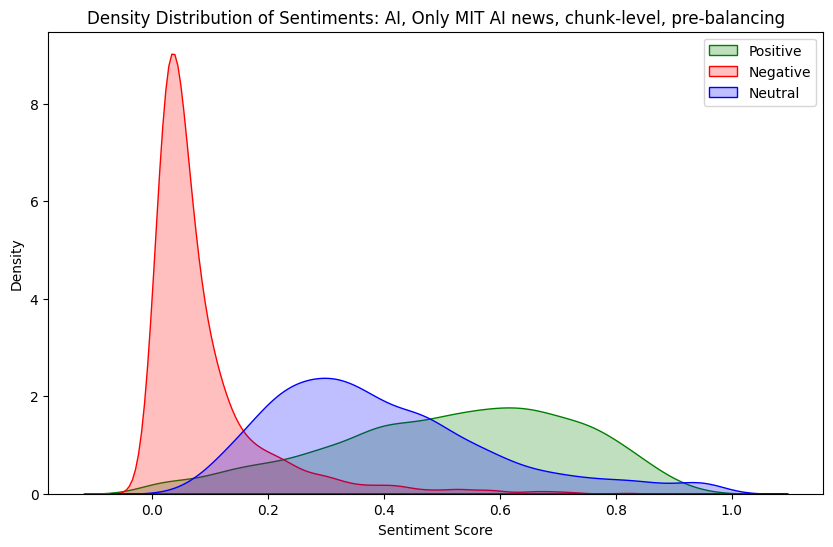

AI_label
AI_POS    1895
AI_NEU    1029
AI_NEG      74
Name: count, dtype: int64


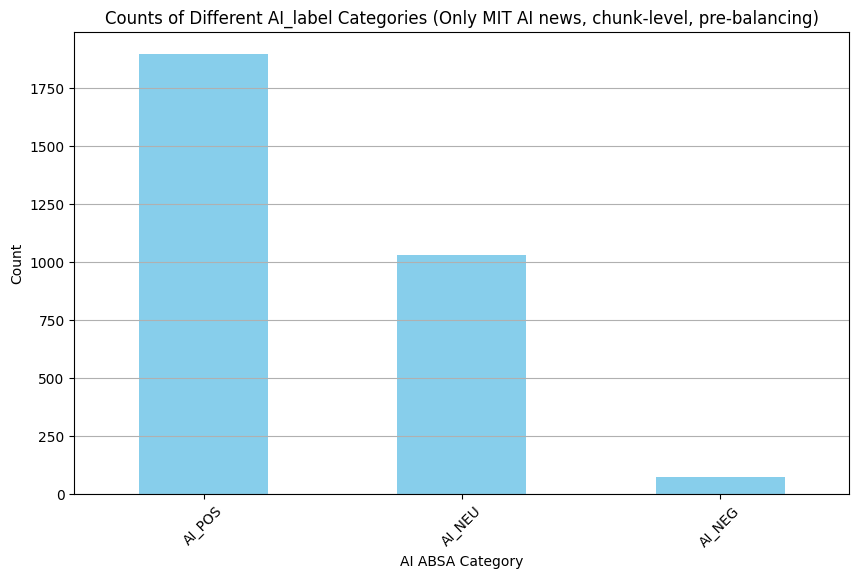

In [33]:
MIT_ai_news = pd.read_csv(f"{path_to_root}/data/old/articles.csv", sep =";").drop(columns = ["Unnamed: 0"])

# -- Chunk articles_aug
from llama_index import VectorStoreIndex, SimpleDirectoryReader, Document

# Convert the DataFrame into a list of Document objects that the index can understand
documents = [Document(text=row['Article Body'],
                      metadata={'title': row['Article Header'],
                                'source': row['Source'],
                                'author': row['Author'],
                                'date': row['Published Date'],
                                'url': row['Url']}) for index, row in MIT_ai_news.iterrows()] 

from llama_index import (
    ServiceContext,
    OpenAIEmbedding,
    PromptHelper,
)
from llama_index.text_splitter import SentenceSplitter

# --- Sentencesplitter to split into chunks
text_splitter = SentenceSplitter(chunk_size=512, chunk_overlap=10)
nodes = text_splitter.get_nodes_from_documents(documents)
nodes = pd.DataFrame(nodes)

# --- Need to format
nodes.rename(columns={7: 'Article Body'}, inplace=True)
nodes['Article Body'] = nodes['Article Body'].astype(str)
print(type(nodes['Article Body']))

aspects = ['AI']

nodes_absa = run_absa_for_dataframe(nodes, aspects)

print("Done with ABSA.")

# --- PLOTTING
import matplotlib.pyplot as plt
import seaborn as sns

def plot_density_distributions(pos_list, neg_list, neu_list):
    plt.figure(figsize=(10, 6))

    sns.kdeplot(pos_list, shade=True, color="g", label="Positive")
    sns.kdeplot(neg_list, shade=True, color="r", label="Negative")
    sns.kdeplot(neu_list, shade=True, color="b", label="Neutral")

    plt.title(f"Density Distribution of Sentiments: {aspect}, Only MIT AI news, chunk-level, pre-balancing")
    plt.xlabel("Sentiment Score")
    plt.ylabel("Density")
    plt.legend()

    plt.show()

for aspect in aspects:
    plot_density_distributions(pos_list = nodes_absa[f'{aspect}_POS'],
                               neg_list = nodes_absa[f'{aspect}_NEG'],
                               neu_list = nodes_absa[f'{aspect}_NEU'])  

# -------------------------
# Function to find the column with the maximum score
def find_max_label(row):
    # Extracting the scores for 'AI' from the row
    scores = {'AI_POS': row['AI_POS'], 'AI_NEU': row['AI_NEU'], 'AI_NEG': row['AI_NEG']}
    # Finding the key with the maximum score
    max_label = max(scores, key=scores.get)
    return max_label

# # FUNC2: Adjust the function to include the new condition for AI_NEU
# def find_max_label_with_neutral_condition(row):
#     # Check if both AI_POS and AI_NEG are between 0.5 and 0.5
#     if 0 <= row['AI_POS'] <= 0.50 and 0 <= row['AI_NEG'] <= 0.50:
#         return 'AI_NEU'
#     else:
#         scores = {'AI_POS': row['AI_POS'], 'AI_NEU': row['AI_NEU'], 'AI_NEG': row['AI_NEG']}
#         max_label = max(scores, key=scores.get)
#         return max_label

def reassign_to_neutral_if_close(row):
    # row already has an initial label assigned
    pos_score = row['AI_POS']
    neg_score = row['AI_NEG']
    
    # Check if the positive and negative scores are within 0.2 of each other
    if abs(pos_score - neg_score) <= 0.1:

        # if they're close return AI_NEU
        return 'AI_NEU'
    else:
        # Return the original label if the scores are not that close
        return row['AI_label']  


def find_max_label_with_combined_conditions(row):
    # Check if both AI_POS and AI_NEG are below 0.5
    if row['AI_POS'] <= 0.5 and row['AI_NEG'] <= 0.5:
        # If they are also within 0.2 of each other, assign 'AI_NEU'
        if abs(row['AI_POS'] - row['AI_NEG']) <= 0.15:
            return 'AI_NEU'
        else:
            # Otherwise, use the highest score
            scores = {'AI_POS': row['AI_POS'], 'AI_NEU': row['AI_NEU'], 'AI_NEG': row['AI_NEG']}
            max_label = max(scores, key=scores.get)
            return max_label
    else:
        # If either is above 0.5, use the highest score
        scores = {'AI_POS': row['AI_POS'], 'AI_NEU': row['AI_NEU'], 'AI_NEG': row['AI_NEG']}
        max_label = max(scores, key=scores.get)
        return max_label


# Apply the function to each row to create the 'AI_label' column
#nodes_absa['AI_label'] = nodes_absa.apply(find_max_label, axis=1)
#nodes_absa['AI_label'] = nodes_absa.apply(reassign_to_neutral_if_close, axis=1)
nodes_absa['AI_label'] = nodes_absa.apply(find_max_label_with_combined_conditions, axis=1)

# Count the occurrences of each category
category_counts_absaai = nodes_absa['AI_label'].value_counts()

# Print the counts
print(category_counts_absaai)

# Plotting
plt.figure(figsize=(10, 6))
category_counts_absaai.plot(kind='bar', color='skyblue')
plt.title('Counts of Different AI_label Categories (Only MIT AI news, chunk-level, pre-balancing)')
plt.xlabel('AI ABSA Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Run ABSA on AUGMENTED DATA - pre balancing

Done with ABSA.


/tmp/ipykernel_863536/3505925852.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pos_list, shade=True, color="g", label="Positive")
/tmp/ipykernel_863536/3505925852.py:38: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neg_list, shade=True, color="r", label="Negative")
/tmp/ipykernel_863536/3505925852.py:39: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neu_list, shade=True, color="b", label="Neutral")


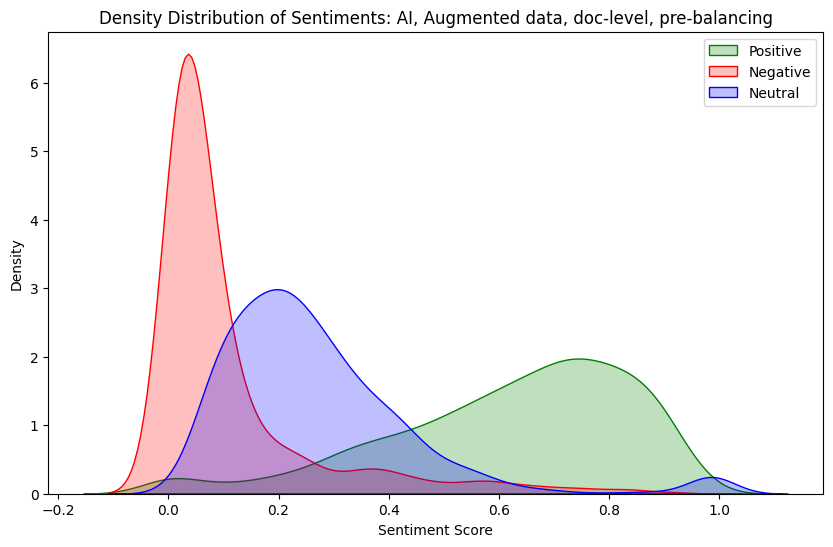

AI_label
AI_POS    969
AI_NEU    192
AI_NEG     67
Name: count, dtype: int64


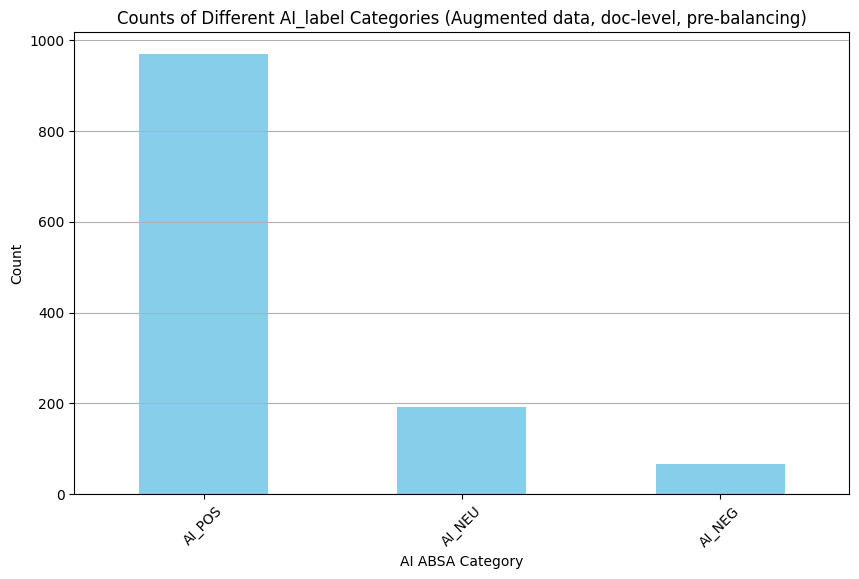

In [34]:
# Make root path
path_to_root = '/work/PernilleHøjlundBrams#8577/NLP_2023_P'

# Get data in
import pandas as pd

MIT_ai_news = pd.read_csv(f"{path_to_root}/data/old/articles.csv", sep =";").drop(columns = ["Unnamed: 0"])
extra_articles = pd.read_csv(f"{path_to_root}/data/extra_articles/extra_articles_23dec.csv", sep = ",").drop(columns = ["Unnamed: 0",'comment'])

# Merge
articles_aug = pd.concat([MIT_ai_news, extra_articles])

# Extract year
import pandas as pd
from datetime import datetime

# Convert 'Published Date' to datetime
articles_aug['Published Date'] = pd.to_datetime(articles_aug['Published Date'])

# Extract the year from the datetime
articles_aug['Year'] = articles_aug['Published Date'].dt.year

# Run function
aspects = ['AI']
           
articles_aug = run_absa_for_dataframe(articles_aug, aspects)
print("Done with ABSA.")


# --- PLOTTING
import matplotlib.pyplot as plt
import seaborn as sns

def plot_density_distributions(pos_list, neg_list, neu_list):
    plt.figure(figsize=(10, 6))

    sns.kdeplot(pos_list, shade=True, color="g", label="Positive")
    sns.kdeplot(neg_list, shade=True, color="r", label="Negative")
    sns.kdeplot(neu_list, shade=True, color="b", label="Neutral")

    plt.title(f"Density Distribution of Sentiments: {aspect}, Augmented data, doc-level, pre-balancing")
    plt.xlabel("Sentiment Score")
    plt.ylabel("Density")
    plt.legend()

    plt.show()

for aspect in aspects:
    plot_density_distributions(pos_list = articles_aug[f'{aspect}_POS'],
                               neg_list = articles_aug[f'{aspect}_NEG'],
                               neu_list = articles_aug[f'{aspect}_NEU'])  

# -------------------------
# Function to find the column with the maximum score
def find_max_label(row):
    # Extracting the scores for 'AI' from the row
    scores = {'AI_POS': row['AI_POS'], 'AI_NEU': row['AI_NEU'], 'AI_NEG': row['AI_NEG']}
    # Finding the key with the maximum score
    max_label = max(scores, key=scores.get)
    return max_label

# # FUNC2: Adjust the function to include the new condition for AI_NEU
# def find_max_label_with_neutral_condition(row):
#     # Check if both AI_POS and AI_NEG are between 0.5 and 0.5
#     if 0 <= row['AI_POS'] <= 0.50 and 0 <= row['AI_NEG'] <= 0.50:
#         return 'AI_NEU'
#     else:
#         scores = {'AI_POS': row['AI_POS'], 'AI_NEU': row['AI_NEU'], 'AI_NEG': row['AI_NEG']}
#         max_label = max(scores, key=scores.get)
#         return max_label

def reassign_to_neutral_if_close(row):
    # row already has an initial label assigned
    pos_score = row['AI_POS']
    neg_score = row['AI_NEG']
    
    # Check if the positive and negative scores are within 0.2 of each other
    if abs(pos_score - neg_score) <= 0.1:

        # if they're close return AI_NEU
        return 'AI_NEU'
    else:
        # Return the original label if the scores are not that close
        return row['AI_label']  


def find_max_label_with_combined_conditions(row):
    # Check if both AI_POS and AI_NEG are below 0.5
    if row['AI_POS'] <= 0.5 and row['AI_NEG'] <= 0.5:
        # If they are also within 0.2 of each other, assign 'AI_NEU'
        if abs(row['AI_POS'] - row['AI_NEG']) <= 0.15:
            return 'AI_NEU'
        else:
            # Otherwise, use the highest score
            scores = {'AI_POS': row['AI_POS'], 'AI_NEU': row['AI_NEU'], 'AI_NEG': row['AI_NEG']}
            max_label = max(scores, key=scores.get)
            return max_label
    else:
        # If either is above 0.5, use the highest score
        scores = {'AI_POS': row['AI_POS'], 'AI_NEU': row['AI_NEU'], 'AI_NEG': row['AI_NEG']}
        max_label = max(scores, key=scores.get)
        return max_label


# Apply the function to each row to create the 'AI_label' column
#articles_aug['AI_label'] = articles_aug.apply(find_max_label, axis=1)
#articles_aug['AI_label'] = articles_aug.apply(reassign_to_neutral_if_close, axis=1)
articles_aug['AI_label'] = articles_aug.apply(find_max_label_with_combined_conditions, axis=1)

# Count the occurrences of each category
category_counts_absaai = articles_aug['AI_label'].value_counts()

# Print the counts
print(category_counts_absaai)

# Plotting
plt.figure(figsize=(10, 6))
category_counts_absaai.plot(kind='bar', color='skyblue')
plt.title('Counts of Different AI_label Categories (Augmented data, doc-level, pre-balancing)')
plt.xlabel('AI ABSA Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

## Chunked augmented data

<class 'pandas.core.series.Series'>
Done with ABSA.


/tmp/ipykernel_863536/1445253988.py:61: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pos_list, shade=True, color="g", label="Positive")
/tmp/ipykernel_863536/1445253988.py:62: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neg_list, shade=True, color="r", label="Negative")
/tmp/ipykernel_863536/1445253988.py:63: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neu_list, shade=True, color="b", label="Neutral")


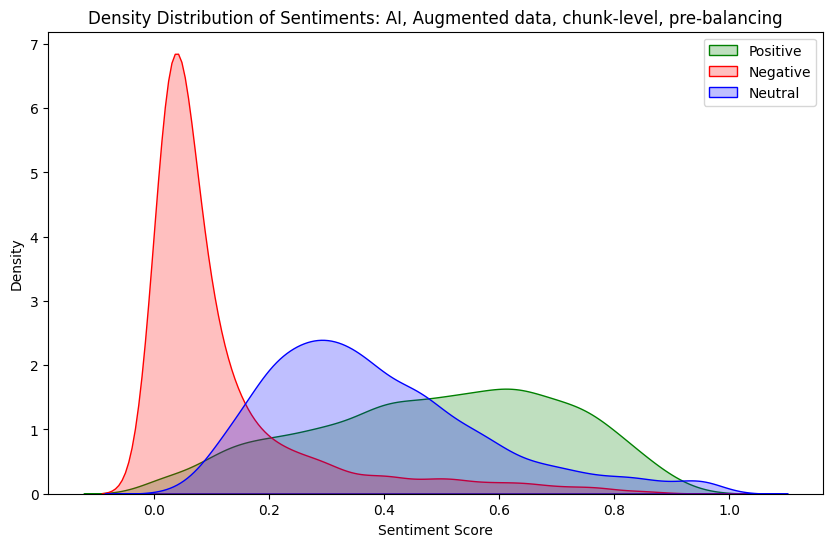

AI_label
AI_POS    2010
AI_NEU    1124
AI_NEG     244
Name: count, dtype: int64


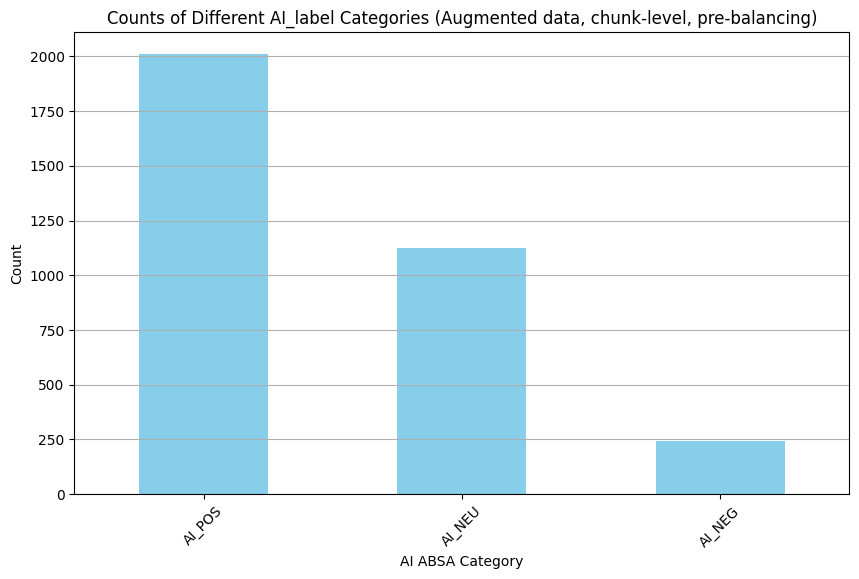

In [38]:
# Get data in
import pandas as pd

MIT_ai_news = pd.read_csv(f"{path_to_root}/data/old/articles.csv", sep =";").drop(columns = ["Unnamed: 0"])
extra_articles = pd.read_csv(f"{path_to_root}/data/extra_articles/extra_articles_23dec.csv", sep = ",").drop(columns = ["Unnamed: 0",'comment'])

# Merge
articles_aug_nodes = pd.concat([MIT_ai_news, extra_articles])

# Extract year
import pandas as pd
from datetime import datetime

# Convert 'Published Date' to datetime
articles_aug_nodes['Published Date'] = pd.to_datetime(articles_aug_nodes['Published Date'])

# Extract the year from the datetime
articles_aug_nodes['Year'] = articles_aug_nodes['Published Date'].dt.year

# -- Chunk articles_aug
from llama_index import VectorStoreIndex, SimpleDirectoryReader, Document

# Convert the DataFrame into a list of Document objects that the index can understand
documents = [Document(text=row['Article Body'],
                      metadata={'title': row['Article Header'],
                                'source': row['Source'],
                                'author': row['Author'],
                                'date': row['Published Date'],
                                'url': row['Url']}) for index, row in articles_aug_nodes.iterrows()] 

from llama_index import (
    ServiceContext,
    OpenAIEmbedding,
    PromptHelper,
)
from llama_index.text_splitter import SentenceSplitter

# --- Sentencesplitter to split into chunks
text_splitter = SentenceSplitter(chunk_size=512, chunk_overlap=10)
nodes = text_splitter.get_nodes_from_documents(documents)
nodes = pd.DataFrame(nodes)

# --- Need to format
nodes.rename(columns={7: 'Article Body'}, inplace=True)
nodes['Article Body'] = nodes['Article Body'].astype(str)
print(type(nodes['Article Body']))

aspects = ['AI']

nodes_absa = run_absa_for_dataframe(nodes, aspects)

print("Done with ABSA.")

# --- PLOTTING
import matplotlib.pyplot as plt
import seaborn as sns

def plot_density_distributions(pos_list, neg_list, neu_list):
    plt.figure(figsize=(10, 6))

    sns.kdeplot(pos_list, shade=True, color="g", label="Positive")
    sns.kdeplot(neg_list, shade=True, color="r", label="Negative")
    sns.kdeplot(neu_list, shade=True, color="b", label="Neutral")

    plt.title(f"Density Distribution of Sentiments: {aspect}, Augmented data, chunk-level, pre-balancing")
    plt.xlabel("Sentiment Score")
    plt.ylabel("Density")
    plt.legend()

    plt.show()

for aspect in aspects:
    plot_density_distributions(pos_list = nodes_absa[f'{aspect}_POS'],
                               neg_list = nodes_absa[f'{aspect}_NEG'],
                               neu_list = nodes_absa[f'{aspect}_NEU'])  

# -------------------------
# Function to find the column with the maximum score
def find_max_label(row):
    # Extracting the scores for 'AI' from the row
    scores = {'AI_POS': row['AI_POS'], 'AI_NEU': row['AI_NEU'], 'AI_NEG': row['AI_NEG']}
    # Finding the key with the maximum score
    max_label = max(scores, key=scores.get)
    return max_label

# # FUNC2: Adjust the function to include the new condition for AI_NEU
# def find_max_label_with_neutral_condition(row):
#     # Check if both AI_POS and AI_NEG are between 0.5 and 0.5
#     if 0 <= row['AI_POS'] <= 0.50 and 0 <= row['AI_NEG'] <= 0.50:
#         return 'AI_NEU'
#     else:
#         scores = {'AI_POS': row['AI_POS'], 'AI_NEU': row['AI_NEU'], 'AI_NEG': row['AI_NEG']}
#         max_label = max(scores, key=scores.get)
#         return max_label

def reassign_to_neutral_if_close(row):
    # row already has an initial label assigned
    pos_score = row['AI_POS']
    neg_score = row['AI_NEG']
    
    # Check if the positive and negative scores are within 0.2 of each other
    if abs(pos_score - neg_score) <= 0.1:

        # if they're close return AI_NEU
        return 'AI_NEU'
    else:
        # Return the original label if the scores are not that close
        return row['AI_label']  

def find_max_label_with_combined_conditions(row):
    # Check if both AI_POS and AI_NEG are below 0.5
    if row['AI_POS'] <= 0.5 and row['AI_NEG'] <= 0.5:
        # If they are also within 0.2 of each other, assign 'AI_NEU'
        if abs(row['AI_POS'] - row['AI_NEG']) <= 0.1:
            return 'AI_NEU'
        else:
            # Otherwise, use the highest score
            scores = {'AI_POS': row['AI_POS'], 'AI_NEU': row['AI_NEU'], 'AI_NEG': row['AI_NEG']}
            max_label = max(scores, key=scores.get)
            return max_label
    else:
        # If either is above 0.5, use the highest score
        scores = {'AI_POS': row['AI_POS'], 'AI_NEU': row['AI_NEU'], 'AI_NEG': row['AI_NEG']}
        max_label = max(scores, key=scores.get)
        return max_label



# Apply the function to each row to create the 'AI_label' column
#nodes_absa['AI_label'] = nodes_absa.apply(find_max_label, axis=1)
#nodes_absa['AI_label'] = nodes_absa.apply(reassign_to_neutral_if_close, axis=1)
nodes_absa['AI_label'] = nodes_absa.apply(find_max_label_with_combined_conditions, axis=1)

# Count the occurrences of each category
category_counts_absaai = nodes_absa['AI_label'].value_counts()

# Print the counts
print(category_counts_absaai)

# Plotting
plt.figure(figsize=(10, 6))
category_counts_absaai.plot(kind='bar', color='skyblue')
plt.title('Counts of Different AI_label Categories (Augmented data, chunk-level, pre-balancing)')
plt.xlabel('AI ABSA Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [37]:
nodes_absa

0                  1  \
0     (id_, c68d463b-34f2-4eb8-be22-9b0f28c092bb)  (embedding, None)   
1     (id_, 607fcad0-428c-4317-8f83-56e8dd2817d2)  (embedding, None)   
2     (id_, d196a520-5be3-4c04-bd03-29906a4d341c)  (embedding, None)   
3     (id_, 9275fc48-e011-400e-b1c5-2b6804703f7f)  (embedding, None)   
4     (id_, 5fba27ab-31c5-4c63-9c9b-333354b81270)  (embedding, None)   
...                                           ...                ...   
3373  (id_, c5395be7-f6b1-45cb-85c5-09b0161ea924)  (embedding, None)   
3374  (id_, 40f8563f-e89b-44ae-9241-d671e8260eb5)  (embedding, None)   
3375  (id_, b5b1f94b-2e0e-4ca4-a443-1d621d9b054f)  (embedding, None)   
3376  (id_, b3f40e76-9261-456c-89da-0cf31b1220f6)  (embedding, None)   
3377  (id_, dd0cce76-071c-481a-87cc-9b86a3389471)  (embedding, None)   

                                                      2  \
0     (metadata, {'title': 'Learning the language of...   
1     (metadata, {'title': 'Learning the language of...   
2     (metadata, {'title': 'Learning the language of...   
3     (metadata, {'title': 'MIT scientists build a s...   
4     (metadata, {'title': 'MIT scientists build a s...   
...                                                 ...   
3373  (metadata, {'title': 'Distributional wants to ...   
3374  (metadata, {'title': 'Distributional wants to ...   
3375  (metadata, {'title': 'Artificial intelligence ...   
3376  (metadata, {'title': 'Artificial intelligence ...   
3377  (metadata, {'title': 'Artificial intelligence ...   

                                       3                                 4  \
0     (excluded_embed_metadata_keys, [])  (excluded_llm_metadata_keys, [])   
1     (excluded_embed_metadata_keys, [])  (excluded_llm_metadata_keys, [])   
2     (excluded_embed_metadata_keys, [])  (excluded_llm_metadata_keys, [])   
3     (excluded_embed_metadata_keys, [])  (excluded_llm_metadata_keys, [])   
4     (excluded_embed_metadata_keys, [])  (excluded_llm_metadata_keys, [])   
...                                  ...                               ...   
3373  (excluded_embed_metadata_keys, [])  (excluded_llm_metadata_keys, [])   
3374  (excluded_embed_metadata_keys, [])  (excluded_llm_metadata_keys, [])   
3375  (excluded_embed_metadata_keys, [])  (excluded_llm_metadata_keys, [])   
3376  (excluded_embed_metadata_keys, [])  (excluded_llm_metadata_keys, [])   
3377  (excluded_embed_metadata_keys, [])  (excluded_llm_metadata_keys, [])   

                                                      5  \
0     (relationships, {'NodeRelationship.SOURCE': no...   
1     (relationships, {'NodeRelationship.SOURCE': no...   
2     (relationships, {'NodeRelationship.SOURCE': no...   
3     (relationships, {'NodeRelationship.SOURCE': no...   
4     (relationships, {'NodeRelationship.SOURCE': no...   
...                                                 ...   
3373  (relationships, {'NodeRelationship.SOURCE': no...   
3374  (relationships, {'NodeRelationship.SOURCE': no...   
3375  (relationships, {'NodeRelationship.SOURCE': no...   
3376  (relationships, {'NodeRelationship.SOURCE': no...   
3377  (relationships, {'NodeRelationship.SOURCE': no...   

                                                      6  \
0     (hash, c1031dc183adef16e1e71b06b300c44bfcd6871...   
1     (hash, d3adb4f12602a0dd4603ba63ed6d231e13ef1b8...   
2     (hash, 8739902b4ba8e0ab96e5d69e3cd0697f9394e23...   
3     (hash, 6e8df09a35c5a293e035c5ab4bf0c112af26b98...   
4     (hash, e9437c3ec387af802047b225eadb73c8836f4f2...   
...                                                 ...   
3373  (hash, d0b798b0e17cdf92784279fa29eee35ab4f3696...   
3374  (hash, b67e9ca0fcca302c7028f9f8973933ddccbc7a4...   
3375  (hash, 8edecfc81818a0a0930a927cc4c6eaba42e27a7...   
3376  (hash, f62b653a26f0d744a1b2a140e7bfe9a95e70bc9...   
3377  (hash, 7eb374d542d4460eeeedd0d06405c1907dd884f...   

                                           Article Body  \
0     ('text', "['Discovering new materials and drug...   
1

In [5]:
#articles_aug = articles_aug.dropna(subset=['Article Body'])
articles_aug

Published Date                Author  \
0       2023-07-07             Adam Zewe   
1       2023-07-06           Alex Ouyang   
2       2023-06-30  Jennifer Michalowski   
3       2023-06-30   Mary Beth Gallagher   
4       2023-06-30             Adam Zewe   
..             ...                   ...   
100     2021-04-22          Miriam Vogel   
101     2021-07-07         Natasha Lomas   
102     2023-12-14    Darrel Etherington   
103     2023-12-14          Kyle Wiggers   
104     2021-03-16      Ismael Al-Amoudi   

                                                Source  \
0                                      MIT News Office   
1    Abdul Latif Jameel Clinic for Machine Learning...   
2                McGovern Institute for Brain Research   
3                                School of Engineering   
4                                      MIT News Office   
..                                                 ...   
100                                         Techcrunch   
101                                         Techcrunch   
102                                         Techcrunch   
103                                         Techcrunch   
104                                   The conversation   

                                        Article Header  \
0    Learning the language of molecules to predict ...   
1    MIT scientists build a system that can generat...   
2    When computer vision works more like a brain, ...   
3    Educating national security leaders on artific...   
4    Researchers teach an AI to write better chart ...   
..                                                 ...   
100  To ensure inclusivity, the Biden administratio...   
101  YouTube’s recommender AI still a horror show, ...   
102  AI isn’t and won’t soon be evil or even smart,...   
103  Distributional wants to develop software to re...   
104  Artificial intelligence and algorithmic irresp...   

                                          Sub_Headings  \
0    This AI system only needs a small amount of da...   
1    BioAutoMATED, an open-source, automated machin...   
2    Training artificial neural networks with data ...   
3    Experts from MIT’s School of Engineering, Schw...   
4    A new dataset can help scientists develop auto...   
..                                                 ...   
100                                                NaN   
101                                                NaN   
102                                                NaN   
103                                                NaN   
104                                                NaN   

                                          Article Body  \
0    ['Discovering new materials and drugs typicall...   
1    ['Is it possible to build machine-learning mod...   
2    ['From cameras to self-driving cars, many of t...   
3    ['Understanding artificial intelligence and ho...   
4    ['Chart captions that explain complex trends a...   
..                                                 ...   
100  The National Security Commission on Artificial...   
101  For years YouTube’s video-recommending algorit...   
102  Artificial intelligence — or rather, the varie...   
103  Companies are increasingly curious about AI an...   
104  The classic 1995 crime film The Usual Suspects...   

                                                   Url    Year    AI_POS  \
0    https://news.mit.edu/2023/learning-language-mo...  2023.0  0.788629   
1    https://news.mit.edu/2023/bioautomated-open-so...  2023.0  0.504995   
2    https://news.mit.edu/2023/when-computer-vision...  2023.0  0.636319   
3    https://news.mit.edu/2023/educating-national-s...  2023.0  0.760746   
4    https://news.mit.edu/2023/researchers-chart-ca...  2023.0  0.905144   
..                                                 ...     ...       ...   
100  https://techcrunch.com/2021/04/22/to-ensure-in...  2021.0  0.900579   
101  https://techcrunch.com/2021/07/07/youtubes-rec...  2021.0  0.850420   
102

In [42]:
# Save df
articles_aug = articles_aug.dropna(subset=['Article Body'])
articles_aug.to_csv(f"{path_to_root}/data/balancing/articles_aug_absa_pre_balance.csv")

nodes_absa = nodes_absa.dropna(subset=['Article Body'])
nodes_absa.to_csv(f"{path_to_root}/data/balancing/nodes_aug_absa_pre_balance.csv")


In [43]:
nodes_absa

0                  1  \
0     (id_, 2d908235-e45a-401a-9ba0-c5b8d6c5b8ba)  (embedding, None)   
1     (id_, 30969f68-80f3-4534-9c82-0537ca9a6564)  (embedding, None)   
2     (id_, fcee1c13-22c0-4e31-8612-35d5c29225be)  (embedding, None)   
3     (id_, 8ab66c38-2579-4dd1-8f3f-9fad2aabd992)  (embedding, None)   
4     (id_, 9ce75f25-84cd-48ff-a768-7ef37d8557e0)  (embedding, None)   
...                                           ...                ...   
3373  (id_, ccfc57cd-c00a-41b7-a989-9cb68eff5c55)  (embedding, None)   
3374  (id_, 82a8e8de-3b59-4fc4-817c-ab719f5cf6e0)  (embedding, None)   
3375  (id_, f80259d4-cea8-44a6-993f-9e5e9aa80ae3)  (embedding, None)   
3376  (id_, aac3fcd6-134b-4933-8c1c-00cbe90e4fb6)  (embedding, None)   
3377  (id_, ff5a5d41-ce3f-428d-b69c-0873aa41e9ff)  (embedding, None)   

                                                      2  \
0     (metadata, {'title': 'Learning the language of...   
1     (metadata, {'title': 'Learning the language of...   
2     (metadata, {'title': 'Learning the language of...   
3     (metadata, {'title': 'MIT scientists build a s...   
4     (metadata, {'title': 'MIT scientists build a s...   
...                                                 ...   
3373  (metadata, {'title': 'Distributional wants to ...   
3374  (metadata, {'title': 'Distributional wants to ...   
3375  (metadata, {'title': 'Artificial intelligence ...   
3376  (metadata, {'title': 'Artificial intelligence ...   
3377  (metadata, {'title': 'Artificial intelligence ...   

                                       3                                 4  \
0     (excluded_embed_metadata_keys, [])  (excluded_llm_metadata_keys, [])   
1     (excluded_embed_metadata_keys, [])  (excluded_llm_metadata_keys, [])   
2     (excluded_embed_metadata_keys, [])  (excluded_llm_metadata_keys, [])   
3     (excluded_embed_metadata_keys, [])  (excluded_llm_metadata_keys, [])   
4     (excluded_embed_metadata_keys, [])  (excluded_llm_metadata_keys, [])   
...                                  ...                               ...   
3373  (excluded_embed_metadata_keys, [])  (excluded_llm_metadata_keys, [])   
3374  (excluded_embed_metadata_keys, [])  (excluded_llm_metadata_keys, [])   
3375  (excluded_embed_metadata_keys, [])  (excluded_llm_metadata_keys, [])   
3376  (excluded_embed_metadata_keys, [])  (excluded_llm_metadata_keys, [])   
3377  (excluded_embed_metadata_keys, [])  (excluded_llm_metadata_keys, [])   

                                                      5  \
0     (relationships, {'NodeRelationship.SOURCE': no...   
1     (relationships, {'NodeRelationship.SOURCE': no...   
2     (relationships, {'NodeRelationship.SOURCE': no...   
3     (relationships, {'NodeRelationship.SOURCE': no...   
4     (relationships, {'NodeRelationship.SOURCE': no...   
...                                                 ...   
3373  (relationships, {'NodeRelationship.SOURCE': no...   
3374  (relationships, {'NodeRelationship.SOURCE': no...   
3375  (relationships, {'NodeRelationship.SOURCE': no...   
3376  (relationships, {'NodeRelationship.SOURCE': no...   
3377  (relationships, {'NodeRelationship.SOURCE': no...   

                                                      6  \
0     (hash, c1031dc183adef16e1e71b06b300c44bfcd6871...   
1     (hash, d3adb4f12602a0dd4603ba63ed6d231e13ef1b8...   
2     (hash, 8739902b4ba8e0ab96e5d69e3cd0697f9394e23...   
3     (hash, 6e8df09a35c5a293e035c5ab4bf0c112af26b98...   
4     (hash, e9437c3ec387af802047b225eadb73c8836f4f2...   
...                                                 ...   
3373  (hash, d0b798b0e17cdf92784279fa29eee35ab4f3696...   
3374  (hash, b67e9ca0fcca302c7028f9f8973933ddccbc7a4...   
3375  (hash, 8edecfc81818a0a0930a927cc4c6eaba42e27a7...   
3376  (hash, f62b653a26f0d744a1b2a140e7bfe9a95e70bc9...   
3377  (hash, 7eb374d542d4460eeeedd0d06405c1907dd884f...   

                                           Article Body  \
0     ('text', "['Discovering new materials and drug...   
1

In [40]:
# Read in
articles_aug = pd.read_csv(f"{path_to_root}/data/balancing/articles_aug_absa_pre_balance.csv").drop(columns = ['Unnamed: 0'])
#articles_aug = articles_aug.dropna(subset=['Article Body'])


Published Date                Author  \
0        2023-07-07             Adam Zewe   
1        2023-07-06           Alex Ouyang   
2        2023-06-30  Jennifer Michalowski   
3        2023-06-30   Mary Beth Gallagher   
4        2023-06-30             Adam Zewe   
...             ...                   ...   
1223            NaN                   NaN   
1224            NaN                   NaN   
1225            NaN                   NaN   
1226            NaN                   NaN   
1227            NaN                   NaN   

                                                 Source  \
0                                       MIT News Office   
1     Abdul Latif Jameel Clinic for Machine Learning...   
2                 McGovern Institute for Brain Research   
3                                 School of Engineering   
4                                       MIT News Office   
...                                                 ...   
1223                                                NaN   
1224                                                NaN   
1225                                                NaN   
1226                                                NaN   
1227                                                NaN   

                                         Article Header  \
0     Learning the language of molecules to predict ...   
1     MIT scientists build a system that can generat...   
2     When computer vision works more like a brain, ...   
3     Educating national security leaders on artific...   
4     Researchers teach an AI to write better chart ...   
...                                                 ...   
1223                                                NaN   
1224                                                NaN   
1225                                                NaN   
1226                                                NaN   
1227                                                NaN   

                                           Sub_Headings  \
0     This AI system only needs a small amount of da...   
1     BioAutoMATED, an open-source, automated machin...   
2     Training artificial neural networks with data ...   
3     Experts from MIT’s School of Engineering, Schw...   
4     A new dataset can help scientists develop auto...   
...                                                 ...   
1223                                                NaN   
1224                                                NaN   
1225                                                NaN   
1226                                                NaN   
1227                                                NaN   

                                           Article Body  \
0     ['Discovering new materials and drugs typicall...   
1     ['Is it possible to build machine-learning mod...   
2     ['From cameras to self-driving cars, many of t...   
3     ['Understanding artificial intelligence and ho...   
4     ['Chart captions that explain complex trends a...   
...                                                 ...   
1223                                                NaN   
1224                                                NaN   
1225                                                NaN   
1226                                                NaN   
1227                                                NaN   

                                                    Url    Year    AI_POS  \
0     https://news.mit.edu/2023/learning-language-mo...  2023.0  0.788629   
1     https://news.mit.edu/2023/bioautomated-open-so...  2023.0  0.504995   
2     https://news.mit.edu/2023/when-computer-vision...  2023.0  0.636319   
3     https://news.mit.edu/2023/educating-national-s...  2023.0  0.760746   
4     https://news.mit.edu/2023/researchers-chart-ca...  2023.0  0.905144   
...                                                 ...     ...       ...   
1223                                                NaN     NaN  0.690589   
1224        

### Plot distributions

/tmp/ipykernel_863536/845839308.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pos_list, shade=True, color="g", label="Positive")
/tmp/ipykernel_863536/845839308.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neg_list, shade=True, color="r", label="Negative")
/tmp/ipykernel_863536/845839308.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neu_list, shade=True, color="b", label="Neutral")


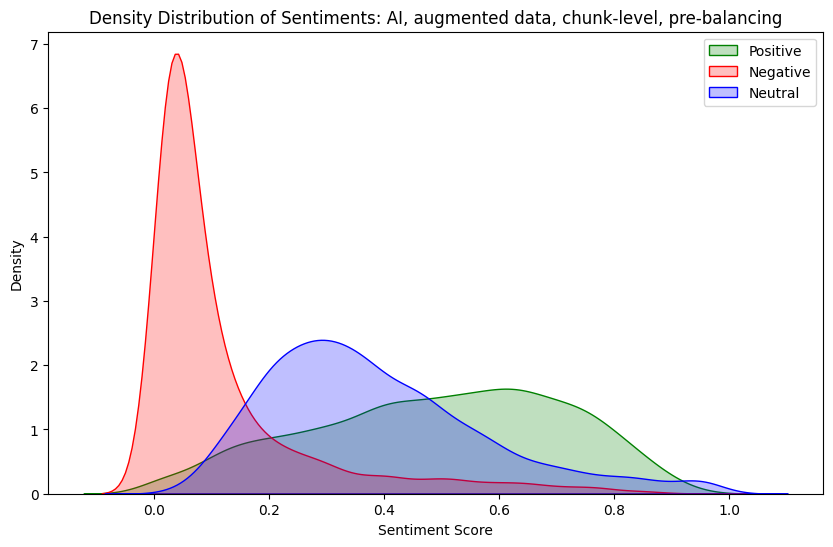

In [44]:
# Plot - see balance prior to balancing on doc level
import matplotlib.pyplot as plt
import seaborn as sns

def plot_density_distributions(pos_list, neg_list, neu_list):
    plt.figure(figsize=(10, 6))

    sns.kdeplot(pos_list, shade=True, color="g", label="Positive")
    sns.kdeplot(neg_list, shade=True, color="r", label="Negative")
    sns.kdeplot(neu_list, shade=True, color="b", label="Neutral")

    plt.title(f"Density Distribution of Sentiments: {aspect}, augmented data, chunk-level, pre-balancing")
    plt.xlabel("Sentiment Score")
    plt.ylabel("Density")
    plt.legend()

    plt.show()

for aspect in aspects:
    plot_density_distributions(pos_list = nodes_absa[f'{aspect}_POS'],
                               neg_list = nodes_absa[f'{aspect}_NEG'],
                               neu_list = nodes_absa[f'{aspect}_NEU'])  

# Balancing

2011.0
2023.0


/tmp/ipykernel_542879/923340955.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pos_list, shade=True, color="g", label="Positive")
/tmp/ipykernel_542879/923340955.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neg_list, shade=True, color="r", label="Negative")
/tmp/ipykernel_542879/923340955.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neu_list, shade=True, color="b", label="Neutral")


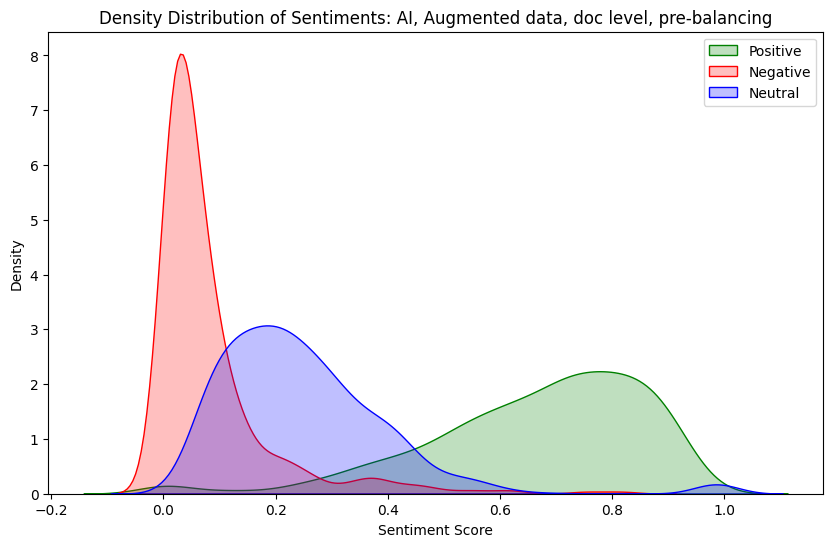

AI_label
AI_POS    832
AI_NEU     69
AI_NEG     39
Name: count, dtype: int64


/tmp/ipykernel_542879/373344532.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles_aug_filt['AI_label'] = articles_aug_filt.apply(find_max_label, axis=1)


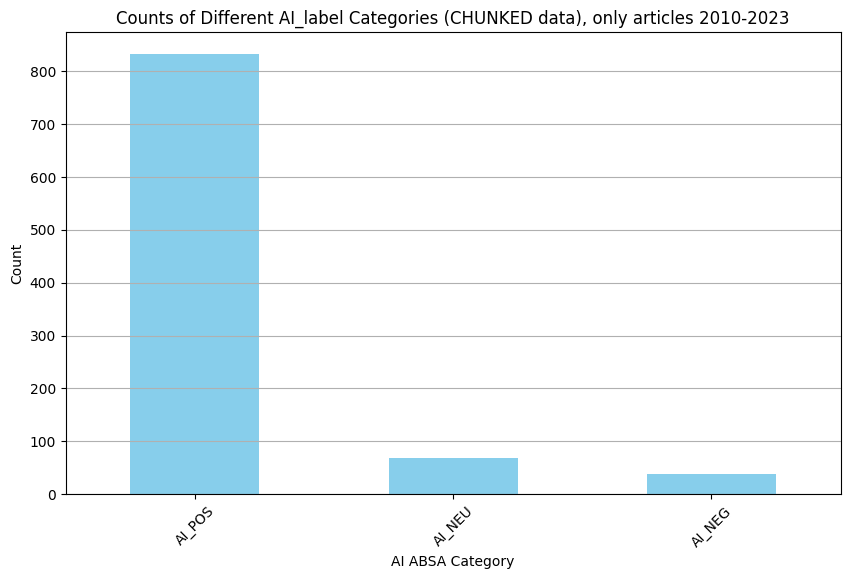

In [44]:
# - Remove 1994-2000
articles_aug_filt = articles_aug[~articles_aug['Year'].between(1994, 2010)]
print(articles_aug_filt['Year'].min())
print(articles_aug_filt['Year'].max())

# Check distribution now
import matplotlib.pyplot as plt
import seaborn as sns

for aspect in aspects:
    plot_density_distributions(pos_list = articles_aug_filt[f'{aspect}_POS'],
                               neg_list = articles_aug_filt[f'{aspect}_NEG'],
                               neu_list = articles_aug_filt[f'{aspect}_NEU'])  

# --- ABSA
import pandas as pd

# Apply the function to each row to create the 'AI_label' column
articles_aug_filt['AI_label'] = articles_aug_filt.apply(find_max_label, axis=1)

# ---- ABSA AI PLOT
# Count the occurrences of each category
category_counts_absaai = articles_aug_filt['AI_label'].value_counts()

# Print the counts
print(category_counts_absaai)

# Plotting
plt.figure(figsize=(10, 6))
category_counts_absaai.plot(kind='bar', color='skyblue')
plt.title('Counts of Different AI_label Categories (CHUNKED data), only articles 2010-2023')
plt.xlabel('AI ABSA Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

### Trying to outsample positive documents

In [45]:
# Randomly sampling out positive and old chunks
import pandas as pd
import numpy as np

# Dataframe with columns 'chunk_id', 'text', 'sentiment_label'
np.random.seed(42)  # For reproducibility

# Get the counts for each sentiment category
counts = articles_aug_filt['AI_label'].value_counts()

# Find the number of chunks to match (the minimum count across sentiments)
min_count = counts.min()

# Function to randomly drop excess chunks
def balance_chunks(dataframe, label, target_count):
    chunks_to_remove = dataframe[dataframe['AI_label'] == label].sample(n=(len(dataframe[dataframe['AI_label'] == label]) - target_count))
    return dataframe.drop(chunks_to_remove.index)

# Balance the dataframe
for sentiment in articles_aug_filt['AI_label'].unique():
    articles_aug_filt = balance_chunks(articles_aug_filt, sentiment, min_count)

# Verify the new distribution
print(articles_aug_filt['AI_label'].value_counts())

AI_label
AI_POS    39
AI_NEU    39
AI_NEG    39
Name: count, dtype: int64


### Plotting again

/tmp/ipykernel_542879/923340955.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pos_list, shade=True, color="g", label="Positive")
/tmp/ipykernel_542879/923340955.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neg_list, shade=True, color="r", label="Negative")
/tmp/ipykernel_542879/923340955.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neu_list, shade=True, color="b", label="Neutral")


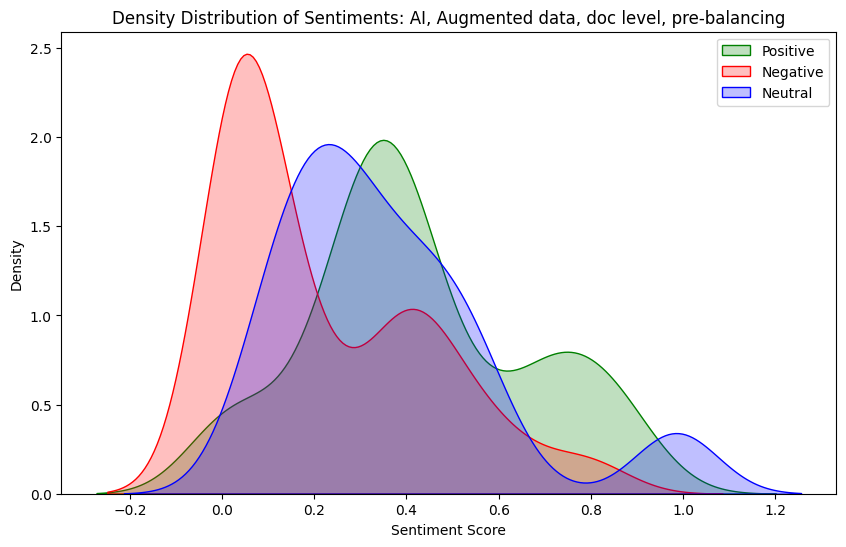

AI_label
AI_POS    39
AI_NEU    39
AI_NEG    39
Name: count, dtype: int64


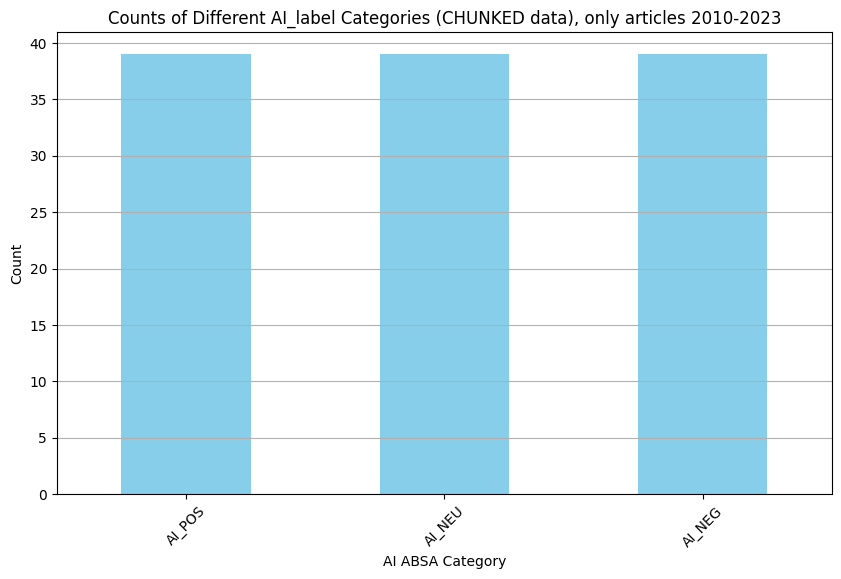

In [47]:
# Check distribution now
import matplotlib.pyplot as plt
import seaborn as sns

for aspect in aspects:
    plot_density_distributions(pos_list = articles_aug_filt[f'{aspect}_POS'],
                               neg_list = articles_aug_filt[f'{aspect}_NEG'],
                               neu_list = articles_aug_filt[f'{aspect}_NEU'])  

# --- ABSA
import pandas as pd

# Apply the function to each row to create the 'AI_label' column
articles_aug_filt['AI_label'] = articles_aug_filt.apply(find_max_label, axis=1)

# ---- ABSA AI PLOT
# Count the occurrences of each category
category_counts_absaai = articles_aug_filt['AI_label'].value_counts()

# Print the counts
print(category_counts_absaai)

# Plotting
plt.figure(figsize=(10, 6))
category_counts_absaai.plot(kind='bar', color='skyblue')
plt.title('Counts of Different AI_label Categories, only articles 2010-2023')
plt.xlabel('AI ABSA Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [49]:
#articles_aug_filt.to_csv(f"{path_to_root}/data/balancing/39_cut.csv")

# Run ABSA - POST balancing (not necessary, AI_LABELS etc are already there)

### Plot distributions

In [ ]:
# Plot - see balance prior to balancing on doc level
import matplotlib.pyplot as plt
import seaborn as sns

def plot_density_distributions(pos_list, neg_list, neu_list):
    plt.figure(figsize=(10, 6))

    sns.kdeplot(pos_list, shade=True, color="g", label="Positive")
    sns.kdeplot(neg_list, shade=True, color="r", label="Negative")
    sns.kdeplot(neu_list, shade=True, color="b", label="Neutral")

    plt.title(f"Density Distribution of Sentiments: {aspect}, doc level, pre-balancing")
    plt.xlabel("Sentiment Score")
    plt.ylabel("Density")
    plt.legend()

    plt.show()

for aspect in aspects:
    plot_density_distributions(pos_list = articles_aug[f'{aspect}_POS'],
                               neg_list = articles_aug[f'{aspect}_NEG'],
                               neu_list = articles_aug[f'{aspect}_NEU'])  

### Plot AI_label counts based on max score

In [ ]:
# Function to find the column with the maximum score
def find_max_label(row):
    # Extracting the scores for 'AI' from the row
    scores = {'AI_POS': row['AI_POS'], 'AI_NEU': row['AI_NEU'], 'AI_NEG': row['AI_NEG']}
    # Finding the key with the maximum score
    max_label = max(scores, key=scores.get)
    return max_label

# Apply the function to each row to create the 'AI_label' column
articles_aug['AI_label'] = articles_aug.apply(find_max_label, axis=1)

# Count the occurrences of each category
category_counts_absaai = articles_aug['AI_label'].value_counts()

# Print the counts
print(category_counts_absaai)

# Plotting
plt.figure(figsize=(10, 6))
category_counts_absaai.plot(kind='bar', color='skyblue')
plt.title('Counts of Different AI_label Categories (pre-balancing, )')
plt.xlabel('AI ABSA Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# ✨ Balancing on chunk level now (create a new index based on the resulting nodes) ✨

### 1. Chunking

In [10]:
# -- Get data
#MIT_ai_news = pd.read_csv(f"{path_to_root}/data/old/articles.csv", sep =";").drop(columns = ["Unnamed: 0"])
#extra_articles = pd.read_csv(f"{path_to_root}/data/extra_articles/extra_articles_23dec.csv", sep = ",").drop(columns = ["Unnamed: 0",'comment'])

# Merge
#articles_aug = pd.concat([MIT_ai_news, extra_articles])

# # Extract year
# import pandas as pd
# from datetime import datetime

# # Convert 'Published Date' to datetime
# articles_aug['Published Date'] = pd.to_datetime(articles_aug['Published Date'])

# # Extract the year from the datetime
# articles_aug['Year'] = articles_aug['Published Date'].dt.year

# articles_aug

Published Date                Author  \
0       2023-07-07             Adam Zewe   
1       2023-07-06           Alex Ouyang   
2       2023-06-30  Jennifer Michalowski   
3       2023-06-30   Mary Beth Gallagher   
4       2023-06-30             Adam Zewe   
..             ...                   ...   
100     2021-04-22          Miriam Vogel   
101     2021-07-07         Natasha Lomas   
102     2023-12-14    Darrel Etherington   
103     2023-12-14          Kyle Wiggers   
104     2021-03-16      Ismael Al-Amoudi   

                                                Source  \
0                                      MIT News Office   
1    Abdul Latif Jameel Clinic for Machine Learning...   
2                McGovern Institute for Brain Research   
3                                School of Engineering   
4                                      MIT News Office   
..                                                 ...   
100                                         Techcrunch   
101                                         Techcrunch   
102                                         Techcrunch   
103                                         Techcrunch   
104                                   The conversation   

                                        Article Header  \
0    Learning the language of molecules to predict ...   
1    MIT scientists build a system that can generat...   
2    When computer vision works more like a brain, ...   
3    Educating national security leaders on artific...   
4    Researchers teach an AI to write better chart ...   
..                                                 ...   
100  To ensure inclusivity, the Biden administratio...   
101  YouTube’s recommender AI still a horror show, ...   
102  AI isn’t and won’t soon be evil or even smart,...   
103  Distributional wants to develop software to re...   
104  Artificial intelligence and algorithmic irresp...   

                                          Sub_Headings  \
0    This AI system only needs a small amount of da...   
1    BioAutoMATED, an open-source, automated machin...   
2    Training artificial neural networks with data ...   
3    Experts from MIT’s School of Engineering, Schw...   
4    A new dataset can help scientists develop auto...   
..                                                 ...   
100                                                NaN   
101                                                NaN   
102                                                NaN   
103                                                NaN   
104                                                NaN   

                                          Article Body  \
0    ['Discovering new materials and drugs typicall...   
1    ['Is it possible to build machine-learning mod...   
2    ['From cameras to self-driving cars, many of t...   
3    ['Understanding artificial intelligence and ho...   
4    ['Chart captions that explain complex trends a...   
..                                                 ...   
100  The National Security Commission on Artificial...   
101  For years YouTube’s video-recommending algorit...   
102  Artificial intelligence — or rather, the varie...   
103  Companies are increasingly curious about AI an...   
104  The classic 1995 crime film The Usual Suspects...   

                                                   Url  Year  
0    https://news.mit.edu/2023/learning-language-mo...  2023  
1    https://news.mit.edu/2023/bioautomated-open-so...  2023  
2    https://news.mit.edu/2023/when-computer-vision...  2023  
3    https://news.mit.edu/2023/educating-national-s...  2023  
4    https://news.mit.edu/2023/researchers-chart-ca...  2023  
..                                                 ...   ...  
100  https://techcrunch.com/2021/04/22/to-ensure-in...  2021  
101  https://techcrunch.com/2021/07/07/youtubes-rec...  2021  
102  https://techcrunch.com/2023/12/14/ai-isnt-and-...  2023  
103  https://techcrunch.com/2023/12/14/distribution...  2

In [12]:
# # -- Chunk articles_aug
# from llama_index import VectorStoreIndex, SimpleDirectoryReader, Document

# # Convert the DataFrame into a list of Document objects that the index can understand
# documents = [Document(text=row['Article Body'],
#                       metadata={'title': row['Article Header'],
#                                 'source': row['Source'],
#                                 'author': row['Author'],
#                                 'date': row['Published Date'],
#                                 'url': row['Url']}) for index, row in articles_aug.iterrows()] 

# from llama_index import (
#     ServiceContext,
#     OpenAIEmbedding,
#     PromptHelper,
# )
# from llama_index.text_splitter import SentenceSplitter

# # --- Sentencesplitter to split into chunks
# text_splitter = SentenceSplitter(chunk_size=512, chunk_overlap=10)
# nodes = text_splitter.get_nodes_from_documents(documents)
# nodes = pd.DataFrame(nodes)

# # check
# print(nodes[7][0])
# nodes

('text', "['Discovering new materials and drugs typically involves a manual, trial-and-error process that can take decades and cost millions of dollars. To streamline this process, scientists often use machine learning to predict molecular properties and narrow down the molecules they need to synthesize and test in the lab.', 'Researchers from MIT and the MIT-Watson AI Lab have developed a new, unified framework that can simultaneously predict molecular properties and generate new molecules much more efficiently than these popular deep-learning approaches.', 'To teach a machine-learning model to predict a molecule’s biological or mechanical properties, researchers must show it millions of labeled molecular structures — a process known as training. Due to the expense of discovering molecules and the challenges of hand-labeling millions of structures, large training datasets are often hard to come by, which limits the effectiveness of machine-learning approaches.', 'By contrast, the syst

0                  1   \
0     (id_, 513b4f6b-3049-4d9f-8057-753d339cc219)  (embedding, None)   
1     (id_, baef0a69-f2fb-4118-849d-e71ca4a6e427)  (embedding, None)   
2     (id_, 78367b9b-e10d-428f-bf6b-ae020930cba2)  (embedding, None)   
3     (id_, 09fe248b-04a3-4767-9d3f-3f3887b1df42)  (embedding, None)   
4     (id_, d44573f5-4ffb-43fd-b262-eaf5981bc106)  (embedding, None)   
...                                           ...                ...   
3373  (id_, aec3db8e-d5f3-4a1c-8880-a8adc6a5c9aa)  (embedding, None)   
3374  (id_, cedd0262-4e9d-4685-8c18-0e8c692d8755)  (embedding, None)   
3375  (id_, a411f7f3-67ee-4b11-be00-4b673f93e95e)  (embedding, None)   
3376  (id_, fcf84e1f-c8f1-415f-9c08-cdebf8419a09)  (embedding, None)   
3377  (id_, 8ebac369-e509-454f-ac25-e44c2f8df0c4)  (embedding, None)   

                                                     2   \
0     (metadata, {'title': 'Learning the language of...   
1     (metadata, {'title': 'Learning the language of...   
2     (metadata, {'title': 'Learning the language of...   
3     (metadata, {'title': 'MIT scientists build a s...   
4     (metadata, {'title': 'MIT scientists build a s...   
...                                                 ...   
3373  (metadata, {'title': 'Distributional wants to ...   
3374  (metadata, {'title': 'Distributional wants to ...   
3375  (metadata, {'title': 'Artificial intelligence ...   
3376  (metadata, {'title': 'Artificial intelligence ...   
3377  (metadata, {'title': 'Artificial intelligence ...   

                                      3                                 4   \
0     (excluded_embed_metadata_keys, [])  (excluded_llm_metadata_keys, [])   
1     (excluded_embed_metadata_keys, [])  (excluded_llm_metadata_keys, [])   
2     (excluded_embed_metadata_keys, [])  (excluded_llm_metadata_keys, [])   
3     (excluded_embed_metadata_keys, [])  (excluded_llm_metadata_keys, [])   
4     (excluded_embed_metadata_keys, [])  (excluded_llm_metadata_keys, [])   
...                                  ...                               ...   
3373  (excluded_embed_metadata_keys, [])  (excluded_llm_metadata_keys, [])   
3374  (excluded_embed_metadata_keys, [])  (excluded_llm_metadata_keys, [])   
3375  (excluded_embed_metadata_keys, [])  (excluded_llm_metadata_keys, [])   
3376  (excluded_embed_metadata_keys, [])  (excluded_llm_metadata_keys, [])   
3377  (excluded_embed_metadata_keys, [])  (excluded_llm_metadata_keys, [])   

                                                     5   \
0     (relationships, {'NodeRelationship.SOURCE': no...   
1     (relationships, {'NodeRelationship.SOURCE': no...   
2     (relationships, {'NodeRelationship.SOURCE': no...   
3     (relationships, {'NodeRelationship.SOURCE': no...   
4     (relationships, {'NodeRelationship.SOURCE': no...   
...                                                 ...   
3373  (relationships, {'NodeRelationship.SOURCE': no...   
3374  (relationships, {'NodeRelationship.SOURCE': no...   
3375  (relationships, {'NodeRelationship.SOURCE': no...   
3376  (relationships, {'NodeRelationship.SOURCE': no...   
3377  (relationships, {'NodeRelationship.SOURCE': no...   

                                                     6   \
0     (hash, c1031dc183adef16e1e71b06b300c44bfcd6871...   
1     (hash, d3adb4f12602a0dd4603ba63ed6d231e13ef1b8...   
2     (hash, 8739902b4ba8e0ab96e5d69e3cd0697f9394e23...   
3     (hash, 6e8df09a35c5a293e035c5ab4bf0c112af26b98...   
4     (hash, e9437c3ec387af802047b225eadb73c8836f4f2...   
...                                                 ...   
3373  (hash, d0b798b0e17cdf92784279fa29eee35ab4f3696...   
3374  (hash, b67e9ca0fcca302c7028f9f8973933ddccbc7a4...   
3375  (hash, 8edecfc81818a0a0930a927cc4c6eaba42e27a7...   
3376  (hash, f62b653a26f0d744a1b2a140e7bfe9a95e70bc9...   
3377  (hash, 7eb374d542d4460eeeedd0d06405c1907dd884f...   

                                                     7   \
0     (text, ['Discovering new materials and drugs t...   


In [13]:
# -- Saving
#nodes.to_csv(f"{path_to_root}/data/balancing/nodes_pre_balance.csv")

### 2. Run ABSA on the chunked augmented data


In [48]:
# Get data
import pandas as pd
nodes_absa = pd.read_csv(f"{path_to_root}/data/balancing/nodes_aug_absa_pre_balance.csv").drop(columns = ['Unnamed: 0'])
nodes_absa

0                    1  \
0     ('id_', '2d908235-e45a-401a-9ba0-c5b8d6c5b8ba')  ('embedding', None)   
1     ('id_', '30969f68-80f3-4534-9c82-0537ca9a6564')  ('embedding', None)   
2     ('id_', 'fcee1c13-22c0-4e31-8612-35d5c29225be')  ('embedding', None)   
3     ('id_', '8ab66c38-2579-4dd1-8f3f-9fad2aabd992')  ('embedding', None)   
4     ('id_', '9ce75f25-84cd-48ff-a768-7ef37d8557e0')  ('embedding', None)   
...                                               ...                  ...   
3373  ('id_', 'ccfc57cd-c00a-41b7-a989-9cb68eff5c55')  ('embedding', None)   
3374  ('id_', '82a8e8de-3b59-4fc4-817c-ab719f5cf6e0')  ('embedding', None)   
3375  ('id_', 'f80259d4-cea8-44a6-993f-9e5e9aa80ae3')  ('embedding', None)   
3376  ('id_', 'aac3fcd6-134b-4933-8c1c-00cbe90e4fb6')  ('embedding', None)   
3377  ('id_', 'ff5a5d41-ce3f-428d-b69c-0873aa41e9ff')  ('embedding', None)   

                                                      2  \
0     ('metadata', {'title': 'Learning the language ...   
1     ('metadata', {'title': 'Learning the language ...   
2     ('metadata', {'title': 'Learning the language ...   
3     ('metadata', {'title': 'MIT scientists build a...   
4     ('metadata', {'title': 'MIT scientists build a...   
...                                                 ...   
3373  ('metadata', {'title': 'Distributional wants t...   
3374  ('metadata', {'title': 'Distributional wants t...   
3375  ('metadata', {'title': 'Artificial intelligenc...   
3376  ('metadata', {'title': 'Artificial intelligenc...   
3377  ('metadata', {'title': 'Artificial intelligenc...   

                                         3  \
0     ('excluded_embed_metadata_keys', [])   
1     ('excluded_embed_metadata_keys', [])   
2     ('excluded_embed_metadata_keys', [])   
3     ('excluded_embed_metadata_keys', [])   
4     ('excluded_embed_metadata_keys', [])   
...                                    ...   
3373  ('excluded_embed_metadata_keys', [])   
3374  ('excluded_embed_metadata_keys', [])   
3375  ('excluded_embed_metadata_keys', [])   
3376  ('excluded_embed_metadata_keys', [])   
3377  ('excluded_embed_metadata_keys', [])   

                                       4  \
0     ('excluded_llm_metadata_keys', [])   
1     ('excluded_llm_metadata_keys', [])   
2     ('excluded_llm_metadata_keys', [])   
3     ('excluded_llm_metadata_keys', [])   
4     ('excluded_llm_metadata_keys', [])   
...                                  ...   
3373  ('excluded_llm_metadata_keys', [])   
3374  ('excluded_llm_metadata_keys', [])   
3375  ('excluded_llm_metadata_keys', [])   
3376  ('excluded_llm_metadata_keys', [])   
3377  ('excluded_llm_metadata_keys', [])   

                                                      5  \
0     ('relationships', {<NodeRelationship.SOURCE: '...   
1     ('relationships', {<NodeRelationship.SOURCE: '...   
2     ('relationships', {<NodeRelationship.SOURCE: '...   
3     ('relationships', {<NodeRelationship.SOURCE: '...   
4     ('relationships', {<NodeRelationship.SOURCE: '...   
...                                                 ...   
3373  ('relationships', {<NodeRelationship.SOURCE: '...   
3374  ('relationships', {<NodeRelationship.SOURCE: '...   
3375  ('relationships', {<NodeRelationship.SOURCE: '...   
3376  ('relationships', {<NodeRelationship.SOURCE: '...   
3377  ('relationships', {<NodeRelationship.SOURCE: '...   

                                                      6  \
0     ('hash', 'c1031dc183adef16e1e71b06b300c44bfcd6...   
1     ('hash', 'd3adb4f12602a0dd4603ba63ed6d231e13ef...   
2     ('hash', '8739902b4ba8e0ab96e5d69e3cd0697f9394...   
3     ('hash', '6e8df09a35c5a293e035c5ab4bf0c112af26...   
4     ('hash', 'e9437c3ec387af802047b225eadb73c8836f...   
...                                                 ...   
3373  ('hash', 'd0b798b0e17cdf92784279fa29eee35ab4f3...   
3374  ('hash', 'b67e9ca0fcca302c7028f9f8973933ddccbc...   
3375  ('hash', '8edecfc81818a0a0930a927cc4c6eaba42e2...   
3376  ('hash', 'f62b653a2

In [ ]:
# # --- Need to format
# #nodes.rename(columns={7: 'Article Body'}, inplace=True)
# nodes['Article Body'] = nodes['Article Body'].astype(str)
# print(type(nodes['Article Body']))

# aspects = ['AI']

# nodes_absa = run_absa_for_dataframe(nodes, aspects)

# print("Done with ABSA.")

# # -------------------------
# # Get label on
# import pandas as pd

# def find_max_label(row):
#     # Extracting the scores for 'AI' from the row
#     scores = {'AI_POS': row['AI_POS'], 'AI_NEU': row['AI_NEU'], 'AI_NEG': row['AI_NEG']}
#     # Finding the key with the maximum score
#     max_label = max(scores, key=scores.get)
#     return max_label
    
# # Apply the function to each row to create the 'AI_label' column
# nodes_absa['AI_label'] = nodes_absa.apply(find_max_label, axis=1)

# # Displaying the first few rows of the updated DataFrame
# nodes_absa

In [17]:
# Check if theyre all zero... or for weird row numbers - should have 3378
#nodes_absa.to_csv(f"{path_to_root}/data/balancing/nodes_absa_23rd.csv")

/tmp/ipykernel_567764/923340955.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pos_list, shade=True, color="g", label="Positive")
/tmp/ipykernel_567764/923340955.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neg_list, shade=True, color="r", label="Negative")
/tmp/ipykernel_567764/923340955.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neu_list, shade=True, color="b", label="Neutral")


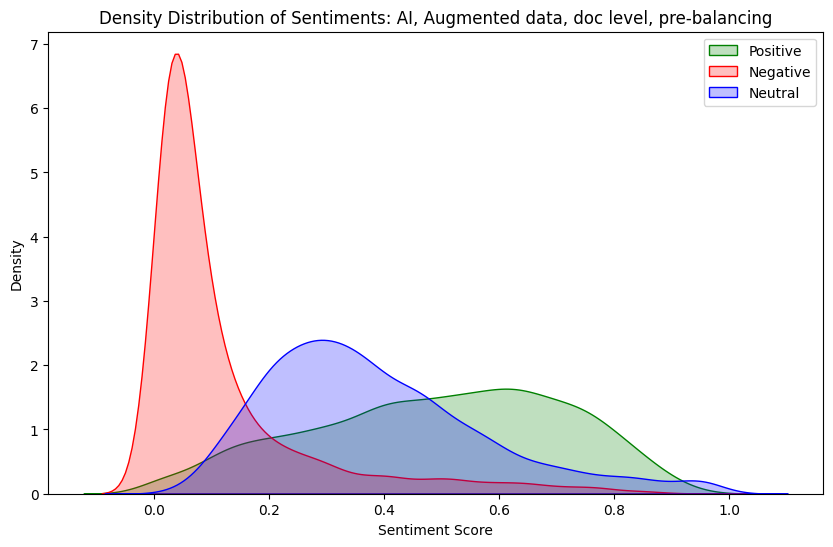

AI_label
AI_POS    2034
AI_NEU    1074
AI_NEG     270
Name: count, dtype: int64


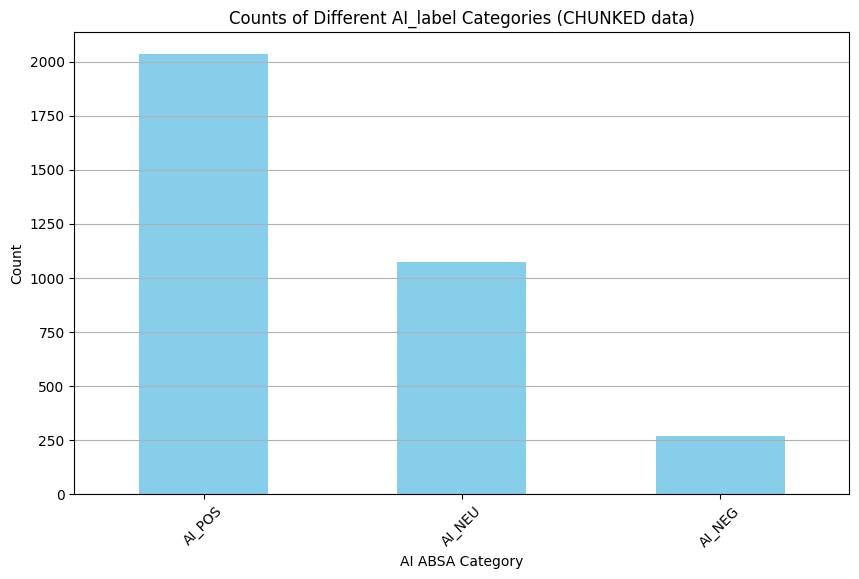

In [19]:
# # Plot
# import matplotlib.pyplot as plt
# import seaborn as sns

# for aspect in aspects:
#     plot_density_distributions(pos_list = nodes_absa[f'{aspect}_POS'],
#                                neg_list = nodes_absa[f'{aspect}_NEG'],
#                                neu_list = nodes_absa[f'{aspect}_NEU'])  


# # ---- ABSA AI PLOT
# # Count the occurrences of each category
# category_counts_absaai = nodes_absa['AI_label'].value_counts()

# # Print the counts
# print(category_counts_absaai)

# # Plotting
# plt.figure(figsize=(10, 6))
# category_counts_absaai.plot(kind='bar', color='skyblue')
# plt.title('Counts of Different AI_label Categories (CHUNKED data)')
# plt.xlabel('AI ABSA Category')
# plt.ylabel('Count')
# plt.xticks(rotation=45)
# plt.grid(axis='y')
# plt.show()

### 3. Outsample positive chunks randomly

In [55]:
# Randomly sampling out positive and old chunks
import pandas as pd
import numpy as np

nodes_absa_downsampled = nodes_absa

# Assume df is your dataframe with columns 'chunk_id', 'text', 'sentiment_label'
np.random.seed(42)  # For reproducibility

# Get the counts for each sentiment category
counts = nodes_absa_downsampled['AI_label'].value_counts()

# Find the number of chunks to match (the minimum count across sentiments)
min_count = counts.min()

# Function to randomly drop excess chunks
def balance_chunks(dataframe, label, target_count):
    chunks_to_remove = dataframe[dataframe['AI_label'] == label].sample(n=(len(dataframe[dataframe['AI_label'] == label]) - target_count))
    return dataframe.drop(chunks_to_remove.index)

# Balance the dataframe
for sentiment in nodes_absa_downsampled['AI_label'].unique():
    nodes_absa_downsampled = balance_chunks(nodes_absa_downsampled, sentiment, min_count)

# Verify the new distribution
print(nodes_absa_downsampled['AI_label'].value_counts())

AI_label
AI_NEU    244
AI_POS    244
AI_NEG    244
Name: count, dtype: int64


### 4. Plot distributions post-sampling out

/tmp/ipykernel_863536/845839308.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pos_list, shade=True, color="g", label="Positive")
/tmp/ipykernel_863536/845839308.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neg_list, shade=True, color="r", label="Negative")
/tmp/ipykernel_863536/845839308.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neu_list, shade=True, color="b", label="Neutral")


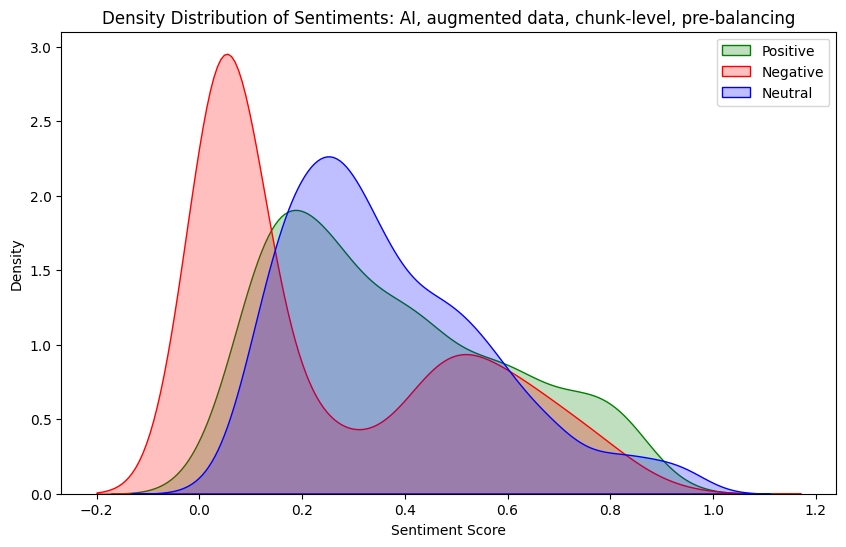

AI_label
AI_NEU    244
AI_POS    244
AI_NEG    244
Name: count, dtype: int64


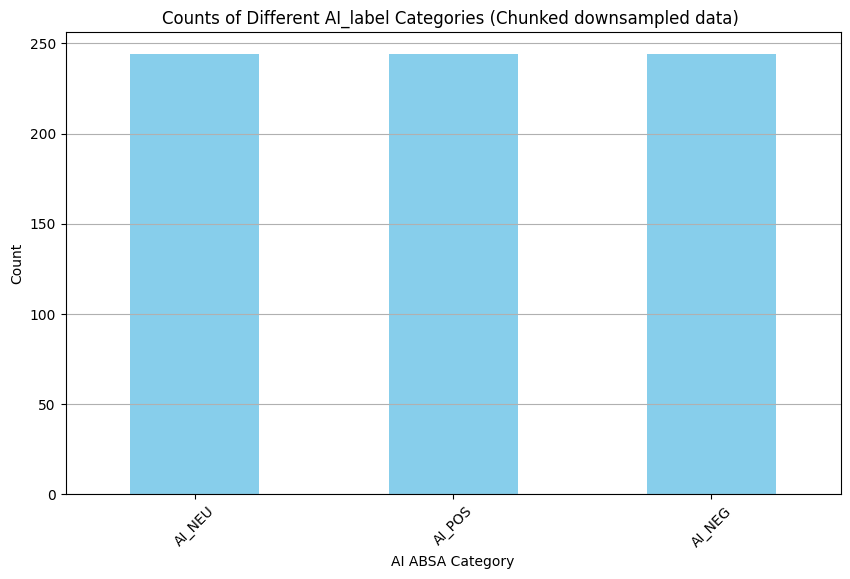

In [58]:
# Check distribution now herhen
import matplotlib.pyplot as plt
import seaborn as sns

for aspect in aspects:
    plot_density_distributions(pos_list = nodes_absa_downsampled[f'{aspect}_POS'],
                               neg_list = nodes_absa_downsampled[f'{aspect}_NEG'],
                               neu_list = nodes_absa_downsampled[f'{aspect}_NEU'])  

# --- ABSA
import pandas as pd

# def find_max_label_with_combined_conditions(row):
#     # Check if both AI_POS and AI_NEG are below 0.5
#     if row['AI_POS'] <= 0.5 and row['AI_NEG'] <= 0.5:
#         # If they are also within 0.2 of each other, assign 'AI_NEU'
#         if abs(row['AI_POS'] - row['AI_NEG']) <= 0.1:
#             return 'AI_NEU'
#         else:
#             # Otherwise, use the highest score
#             scores = {'AI_POS': row['AI_POS'], 'AI_NEU': row['AI_NEU'], 'AI_NEG': row['AI_NEG']}
#             max_label = max(scores, key=scores.get)
#             return max_label
#     else:
#         # If either is above 0.5, use the highest score
#         scores = {'AI_POS': row['AI_POS'], 'AI_NEU': row['AI_NEU'], 'AI_NEG': row['AI_NEG']}
#         max_label = max(scores, key=scores.get)
#         return max_label

# Apply the function to each row to create the 'AI_label' column
#nodes_absa_downsampled['AI_label'] = nodes_absa_downsampled.apply(find_max_label_with_combined_conditions, axis=1)

# ---- ABSA AI PLOT
# Count the occurrences of each category
category_counts_absaai = nodes_absa_downsampled['AI_label'].value_counts()

# Print the counts
print(category_counts_absaai)

# Plotting
plt.figure(figsize=(10, 6))
category_counts_absaai.plot(kind='bar', color='skyblue')
plt.title('Counts of Different AI_label Categories (Chunked downsampled data) ')
plt.xlabel('AI ABSA Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In [59]:
#nodes_absa_downsampled.to_csv(f"{path_to_root}/data/balancing/nodes_aug_absa_post_balance.csv")


### 5. Topic modelling to find topics

In [105]:
# function needed
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd
import string
import nltk

def run_topic_modeling(dataframe, text_column, num_topics=30, num_words=10):
    nltk.download('stopwords')
    nltk.download('wordnet')

    stopwords_extra = ['some', 'additional', 'stopwords']
    custom_stopwords = ['say', 'says', 'said', 'also', 'one', 'two', 'three', 'mit', 'the', '—','ai','make','may','could','like','would','use''videgaray']
    stop_words = set(stopwords.words('english')).union(stopwords_extra, custom_stopwords)
    exclude = set(string.punctuation)
    lemma = WordNetLemmatizer()

    def preprocess_text(text):
        tokens = word_tokenize(text.lower())
        tokens = [lemma.lemmatize(word) for word in tokens if word not in stop_words and word.isalnum()]
        return tokens

    texts = dataframe[text_column].apply(preprocess_text)
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)
    dataframe['main_topic'] = [sorted(lda_model[corpus[i]], key=lambda x: x[1], reverse=True)[0][0] for i in range(len(dataframe))]

    top_words_per_topic = lda_model.print_topics(num_topics=num_topics, num_words=num_words)
    for topic in top_words_per_topic:
        print(topic)

    return dataframe, lda_model

# Example usage
# path_to_root = 'your_path'
nodes_absa_downsampled = pd.read_csv(f"{path_to_root}/data/balancing/nodes_aug_absa_post_balance.csv").drop(columns = ['Unnamed: 0'])
# nodes_absa_downsampled, lda_model = run_topic_modeling(nodes_absa_downsampled, 'Article Body', num_topics=30, num_words=10)


In [ ]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pandas as pd
import string


from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
import nltk

np.random.seed(41)  # For reproducibility

# Get data
nodes_absa_downsampled = pd.read_csv(f"{path_to_root}/data/balancing/nodes_aug_absa_post_balance.csv").drop(columns = ['Unnamed: 0'])

nodes_absa_downsampled, lda_model = run_topic_modeling(nodes_absa_downsampled, 'Article Body', num_topics=15, num_words=10)

# Group by main topic and AI_label, then count occurrences
topic_sentiment_counts = nodes_absa_downsampled.groupby(['main_topic', 'AI_label']).size().unstack(fill_value=0)

# Find topics that are present in all three sentiment labels
topics_in_all_sentiments = topic_sentiment_counts[(topic_sentiment_counts['AI_POS'] > 0) & (topic_sentiment_counts['AI_NEG'] > 0) & (topic_sentiment_counts['AI_NEU'] > 0)]

print(topics_in_all_sentiments)


In [121]:
from gensim import corpora
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd
import string
import nltk

np.random.seed(38)  # For reproducibility

nodes_absa_downsampled = pd.read_csv(f"{path_to_root}/data/balancing/nodes_aug_absa_post_balance.csv").drop(columns = ['Unnamed: 0'])

# have your dataframe 'nodes_absa_downsampled' ready
nltk.download('stopwords')
nltk.download('wordnet')

# Preprocessing
stop_words = set(stopwords.words('english')).union(['some', 'additional', 'stopwords'])
lemma = WordNetLemmatizer()
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    return [lemma.lemmatize(word) for word in tokens if word not in stop_words and word.isalnum()]

# Preprocess the texts
texts = nodes_absa_downsampled['Article Body'].apply(preprocess_text)

# Create Dictionary and Corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Find Optimal Number of Topics
coherence_values = []
for num_topics in range(5, 50, 2): # Training models set to start at 5, increase with stepsize 5
    model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10)
    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

# Get the optimal number of topics
max_coherence_val = max(coherence_values)
optimal_k = (coherence_values.index(max_coherence_val) + 1) * 5

print("Optimal number of topics:", optimal_k)

# Run the topic modeling with optimal number of topics
nodes_absa_downsampled, lda_model = run_topic_modeling(nodes_absa_downsampled, 'Article Body', num_topics=optimal_k, num_words=10)


[nltk_data] Downloading package stopwords to /home/ucloud/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ucloud/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Optimal number of topics: 25


[nltk_data] Downloading package stopwords to /home/ucloud/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ucloud/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


(0, '0.011*"system" + 0.009*"algorithm" + 0.007*"model" + 0.007*"technology" + 0.006*"researcher" + 0.005*"patient" + 0.005*"problem" + 0.004*"data" + 0.004*"decision" + 0.004*"human"')
(1, '0.012*"model" + 0.008*"data" + 0.007*"system" + 0.006*"researcher" + 0.006*"risk" + 0.005*"new" + 0.005*"use" + 0.004*"human" + 0.004*"machine" + 0.004*"people"')
(2, '0.015*"image" + 0.014*"child" + 0.009*"company" + 0.008*"abuse" + 0.006*"laion" + 0.005*"report" + 0.005*"woman" + 0.005*"imagery" + 0.005*"stanford" + 0.005*"tool"')
(3, '0.011*"robot" + 0.007*"model" + 0.007*"researcher" + 0.006*"object" + 0.005*"research" + 0.005*"video" + 0.004*"system" + 0.004*"team" + 0.004*"student" + 0.004*"paper"')
(4, '0.006*"user" + 0.006*"youtube" + 0.006*"image" + 0.005*"video" + 0.005*"content" + 0.005*"tensor" + 0.004*"algorithm" + 0.004*"system" + 0.004*"right" + 0.004*"researcher"')
(5, '0.012*"image" + 0.011*"data" + 0.011*"model" + 0.007*"research" + 0.007*"science" + 0.006*"neural" + 0.006*"networ

In [123]:
# Group by main topic and AI_label, then count occurrences
topic_sentiment_counts = nodes_absa_downsampled.groupby(['main_topic', 'AI_label']).size().unstack(fill_value=0)

# Find topics that are present in all three sentiment labels
topics_in_all_sentiments = topic_sentiment_counts[(topic_sentiment_counts['AI_POS'] > 0) & (topic_sentiment_counts['AI_NEG'] > 0) & (topic_sentiment_counts['AI_NEU'] > 0)]

topics_in_all_sentiments

AI_label    AI_NEG  AI_NEU  AI_POS
main_topic                        
0               12      15       6
1               55      19      31
2                5       1       4
3                7      10      10
4                8       3       7
5                7       5      11
6               16       9       7
7                6      12       7
8               15      15      20
9                6      15      16
10              16       6       6
11               8      11       5
12              12      10       7
13               6      15      33
14               8       8       5
15               7      24      19
16               6       6       9
17               6       4       2
18               4      10       5
19               5       9       8
21               6      10       5
22               5       6       5
23              14       8       6
24               4      11       6

In [134]:
# Dictionary mapping topic numbers to names
topic_names = {
    0: "Systems and algorithms",
    1: "Modeling and data systems",
    2: "Child safety and images",
    3: "Robotics and modeling",
    4: "Education and content generation",
    5: "Imaging and data science",
    6: "Language models",
    7: "Medical technology",
    8: "Scientific research",
    9: "Medical diagnostics",
    10: "Political analysis",
    11: "Technology and people",
    12: "Data models and systems",
    13: "New learning systems",
    14: "Scientific research",
    15: "Data Science and Computing", # NOTE concatenate?
    16: "Engineering",
    17: "Gen-ai and systems networks",
    18: "Scientific research",
    19: "Technology and worker science",
    20: "Brain research and drugs",
    21: "College and new technologies",
    22: "Systems data and financial systems",
    23: "Systems data and financial systems",
    24: "Robotics"
}

# Function to map topic number to topic name
def get_topic_name(topic_number):
    return topic_names.get(topic_number, "Unknown")

# Create a new column for topic names
nodes_absa_downsampled['topic_name'] = nodes_absa_downsampled['main_topic'].apply(get_topic_name)


In [135]:
# Group by main topic and AI_label, then count occurrences
topic_sentiment_counts = nodes_absa_downsampled.groupby(['topic_name', 'AI_label']).size().unstack(fill_value=0)

# Find topics that are present in all three sentiment labels
topics_in_all_sentiments = topic_sentiment_counts[(topic_sentiment_counts['AI_POS'] > 0) & (topic_sentiment_counts['AI_NEG'] > 0) & (topic_sentiment_counts['AI_NEU'] > 0)]

# Filter the data to only have the topics below: 
topics_in_all_sentiments

AI_label                            AI_NEG  AI_NEU  AI_POS
topic_name                                                
Child safety and images                  5       1       4
College and new technologies             6      10       5
Data Science and Computing               7      24      19
Data models and systems                 12      10       7
Education and content generation         8       3       7
Engineering                              6       6       9
Gen-ai and systems networks              6       4       2
Imaging and data science                 7       5      11
Language models                         16       9       7
Medical diagnostics                      6      15      16
Medical technology                       6      12       7
Modeling and data systems               55      19      31
New learning systems                     6      15      33
Political analysis                      16       6       6
Robotics                                 4      11       6
Robotics and modeling                    7      10      10
Scientific research                     27      33      30
Systems and algorithms                  12      15       6
Systems data and financial systems      19      14      11
Technology and people                    8      11       5
Technology and worker science            5       9       8

In [136]:
# Extracting topic names that are present in all sentiment labels
topics_to_keep = topics_in_all_sentiments.index.tolist()

# Filtering the original dataframe
filtered_nodes_absa_downsampled = nodes_absa_downsampled[nodes_absa_downsampled['topic_name'].isin(topics_to_keep)]

#filtered_nodes_absa_downsampled.to_csv(f"{path_to_root}/data/balancing/nodes_aug_absa_post_balance_w_filtered_topics.csv")

In [233]:
filtered_nodes_absa_downsampled = pd.read_csv(f"{path_to_root}/data/balancing/nodes_aug_absa_post_balance_w_filtered_topics.csv")
filtered_nodes_absa_downsampled

Unnamed: 0                                                0  \
0             0  ('id_', '8ab66c38-2579-4dd1-8f3f-9fad2aabd992')   
1             1  ('id_', '9ce75f25-84cd-48ff-a768-7ef37d8557e0')   
2             2  ('id_', '71d24f9e-ccc9-447f-8f2a-4b240d4778de')   
3             3  ('id_', '15e32c0d-f9c3-493c-8c4d-826e19d1c00d')   
4             4  ('id_', '00c15221-42f6-4ce7-91d4-8db641a967a1')   
..          ...                                              ...   
721         727  ('id_', 'b1abd622-dd21-4232-86b5-94edc3f90e19')   
722         728  ('id_', '38382e06-9992-4abf-9e65-9609b4e21986')   
723         729  ('id_', 'f80259d4-cea8-44a6-993f-9e5e9aa80ae3')   
724         730  ('id_', 'aac3fcd6-134b-4933-8c1c-00cbe90e4fb6')   
725         731  ('id_', 'ff5a5d41-ce3f-428d-b69c-0873aa41e9ff')   

                       1                                                  2  \
0    ('embedding', None)  ('metadata', {'title': 'MIT scientists build a...   
1    ('embedding', None)  ('metadata', {'title': 'MIT scientists build a...   
2    ('embedding', None)  ('metadata', {'title': 'Gamifying medical data...   
3    ('embedding', None)  ('metadata', {'title': 'Gamifying medical data...   
4    ('embedding', None)  ('metadata', {'title': 'Envisioning the future...   
..                   ...                                                ...   
721  ('embedding', None)  ('metadata', {'title': 'AI isn’t and won’t soo...   
722  ('embedding', None)  ('metadata', {'title': 'AI isn’t and won’t soo...   
723  ('embedding', None)  ('metadata', {'title': 'Artificial intelligenc...   
724  ('embedding', None)  ('metadata', {'title': 'Artificial intelligenc...   
725  ('embedding', None)  ('metadata', {'title': 'Artificial intelligenc...   

                                        3                                   4  \
0    ('excluded_embed_metadata_keys', [])  ('excluded_llm_metadata_keys', [])   
1    ('excluded_embed_metadata_keys', [])  ('excluded_llm_metadata_keys', [])   
2    ('excluded_embed_metadata_keys', [])  ('excluded_llm_metadata_keys', [])   
3    ('excluded_embed_metadata_keys', [])  ('excluded_llm_metadata_keys', [])   
4    ('excluded_embed_metadata_keys', [])  ('excluded_llm_metadata_keys', [])   
..                                    ...                                 ...   
721  ('excluded_embed_metadata_keys', [])  ('excluded_llm_metadata_keys', [])   
722  ('excluded_embed_metadata_keys', [])  ('excluded_llm_metadata_keys', [])   
723  ('excluded_embed_metadata_keys', [])  ('excluded_llm_metadata_keys', [])   
724  ('excluded_embed_metadata_keys', [])  ('excluded_llm_metadata_keys', [])   
725  ('excluded_embed_metadata_keys', [])  ('excluded_llm_metadata_keys', [])   

                                                     5  \
0    ('relationships', {<NodeRelationship.SOURCE: '...   
1    ('relationships', {<NodeRelationship.SOURCE: '...   
2    ('relationships', {<NodeRelationship.SOURCE: '...   
3    ('relationships', {<NodeRelationship.SOURCE: '...   
4    ('relationships', {<NodeRelationship.SOURCE: '...   
..                                                 ...   
721  ('relationships', {<NodeRelationship.SOURCE: '...   
722  ('relationships', {<NodeRelationship.SOURCE: '...   
723  ('relationships', {<NodeRelationship.SOURCE: '...   
724  ('relationships', {<NodeRelationship.SOURCE: '...   
725  ('relationships', {<NodeRelationship.SOURCE: '...   

                                                     6  \
0    ('hash', '6e8df09a35c5a293e035c5ab4bf0c112af26...   
1    ('hash', 'e9437c3ec387af802047b225eadb73c8836f...   
2    ('hash', '14f9f1d16ac662ac2649cb849af2d57fd81f...   
3    ('hash', '81ca2f580448dd118bc5e740e797fd0739cb...   
4    ('hash', '01998502b66a9cb091c7fe44bee3907a7af7...   
..                                                 ...   
721  ('hash', '66ed3867d46ece8e85e7a418b916015754ed...   
722  ('hash', '1a9a99a62a024e9896c5de21417043692088...   
723  ('hash', '8edecfc81818a0a0930a927cc4c6eaba

## Prepare data for indexing


In [176]:
# import pandas as pd

# MIT_ai_news = pd.read_csv(f"{path_to_root}/data/old/articles.csv", sep =";").drop(columns = ["Unnamed: 0"])
# extra_articles = pd.read_csv(f"{path_to_root}/data/extra_articles/extra_articles_23dec.csv", sep = ",").drop(columns = ["Unnamed: 0",'comment'])

# # Merge
# articles_aug_nodes = pd.concat([MIT_ai_news, extra_articles])

# # Extract year
# import pandas as pd
# from datetime import datetime

# # Convert 'Published Date' to datetime
# articles_aug_nodes['Published Date'] = pd.to_datetime(articles_aug_nodes['Published Date'])

# # Extract the year from the datetime
# articles_aug_nodes['Year'] = articles_aug_nodes['Published Date'].dt.year

# # -- Chunk articles_aug
# from llama_index import VectorStoreIndex, SimpleDirectoryReader, Document

# # Convert the DataFrame into a list of Document objects that the index can understand
# documents = [Document(text=row['Article Body'],
#                       metadata={'title': row['Article Header'],
#                                 'source': row['Source'],
#                                 'author': row['Author'],
#                                 #'date': row['Published Date'],
#                                 'url': row['Url']}) for index, row in articles_aug_nodes.iterrows()] 

# from llama_index import (
#     ServiceContext,
#     OpenAIEmbedding,
#     PromptHelper,
# )
# from llama_index.text_splitter import SentenceSplitter

# # --- Sentencesplitter to split into chunks
# text_splitter = SentenceSplitter(chunk_size=512, chunk_overlap=10)
# nodes = text_splitter.get_nodes_from_documents(documents)
# nodes_df = pd.DataFrame(nodes)


In [177]:
# # Take dataset (filtered_nodes_absa_downsampled) and get snippet

# import pandas as pd
# import re

# def extract_text_snippet(text):
#     # Use regular expression to extract the text between ('text', "..." or 'text', '...')
#     match = re.search(r"\('text', [\"'](.*?)[\"']\)$", text, re.DOTALL)
#     if match:
#         # Extract the actual text content
#         actual_text = match.group(1)

#         # Split into tokens and return the first 10-15 tokens
#         tokens = actual_text.split()
#         return ' '.join(tokens[:15])  # Adjust the number as needed (10-15 tokens)
#     else:
#         return None

# # Convert 'Article Body' column to string before applying the function
# filtered_nodes_absa_downsampled['Article Body'] = filtered_nodes_absa_downsampled['Article Body'].astype(str)

# # Apply the function to the 'Article Body' column
# filtered_nodes_absa_downsampled['extracted_text'] = filtered_nodes_absa_downsampled['Article Body'].apply(extract_text_snippet)

# # Display the DataFrame
# filtered_nodes_absa_downsampled

/tmp/ipykernel_863536/4250750939.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_nodes_absa_downsampled['Article Body'] = filtered_nodes_absa_downsampled['Article Body'].astype(str)
/tmp/ipykernel_863536/4250750939.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_nodes_absa_downsampled['extracted_text'] = filtered_nodes_absa_downsampled['Article Body'].apply(extract_text_snippet)


0                    1  \
0    ('id_', '8ab66c38-2579-4dd1-8f3f-9fad2aabd992')  ('embedding', None)   
1    ('id_', '9ce75f25-84cd-48ff-a768-7ef37d8557e0')  ('embedding', None)   
2    ('id_', '71d24f9e-ccc9-447f-8f2a-4b240d4778de')  ('embedding', None)   
3    ('id_', '15e32c0d-f9c3-493c-8c4d-826e19d1c00d')  ('embedding', None)   
4    ('id_', '00c15221-42f6-4ce7-91d4-8db641a967a1')  ('embedding', None)   
..                                               ...                  ...   
727  ('id_', 'b1abd622-dd21-4232-86b5-94edc3f90e19')  ('embedding', None)   
728  ('id_', '38382e06-9992-4abf-9e65-9609b4e21986')  ('embedding', None)   
729  ('id_', 'f80259d4-cea8-44a6-993f-9e5e9aa80ae3')  ('embedding', None)   
730  ('id_', 'aac3fcd6-134b-4933-8c1c-00cbe90e4fb6')  ('embedding', None)   
731  ('id_', 'ff5a5d41-ce3f-428d-b69c-0873aa41e9ff')  ('embedding', None)   

                                                     2  \
0    ('metadata', {'title': 'MIT scientists build a...   
1    ('metadata', {'title': 'MIT scientists build a...   
2    ('metadata', {'title': 'Gamifying medical data...   
3    ('metadata', {'title': 'Gamifying medical data...   
4    ('metadata', {'title': 'Envisioning the future...   
..                                                 ...   
727  ('metadata', {'title': 'AI isn’t and won’t soo...   
728  ('metadata', {'title': 'AI isn’t and won’t soo...   
729  ('metadata', {'title': 'Artificial intelligenc...   
730  ('metadata', {'title': 'Artificial intelligenc...   
731  ('metadata', {'title': 'Artificial intelligenc...   

                                        3                                   4  \
0    ('excluded_embed_metadata_keys', [])  ('excluded_llm_metadata_keys', [])   
1    ('excluded_embed_metadata_keys', [])  ('excluded_llm_metadata_keys', [])   
2    ('excluded_embed_metadata_keys', [])  ('excluded_llm_metadata_keys', [])   
3    ('excluded_embed_metadata_keys', [])  ('excluded_llm_metadata_keys', [])   
4    ('excluded_embed_metadata_keys', [])  ('excluded_llm_metadata_keys', [])   
..                                    ...                                 ...   
727  ('excluded_embed_metadata_keys', [])  ('excluded_llm_metadata_keys', [])   
728  ('excluded_embed_metadata_keys', [])  ('excluded_llm_metadata_keys', [])   
729  ('excluded_embed_metadata_keys', [])  ('excluded_llm_metadata_keys', [])   
730  ('excluded_embed_metadata_keys', [])  ('excluded_llm_metadata_keys', [])   
731  ('excluded_embed_metadata_keys', [])  ('excluded_llm_metadata_keys', [])   

                                                     5  \
0    ('relationships', {<NodeRelationship.SOURCE: '...   
1    ('relationships', {<NodeRelationship.SOURCE: '...   
2    ('relationships', {<NodeRelationship.SOURCE: '...   
3    ('relationships', {<NodeRelationship.SOURCE: '...   
4    ('relationships', {<NodeRelationship.SOURCE: '...   
..                                                 ...   
727  ('relationships', {<NodeRelationship.SOURCE: '...   
728  ('relationships', {<NodeRelationship.SOURCE: '...   
729  ('relationships', {<NodeRelationship.SOURCE: '...   
730  ('relationships', {<NodeRelationship.SOURCE: '...   
731  ('relationships', {<NodeRelationship.SOURCE: '...   

                                                     6  \
0    ('hash', '6e8df09a35c5a293e035c5ab4bf0c112af26...   
1    ('hash', 'e9437c3ec387af802047b225eadb73c8836f...   
2    ('hash', '14f9f1d16ac662ac2649cb849af2d57fd81f...   
3    ('hash', '81ca2f580448dd118bc5e740e797fd0739cb...   
4    ('hash', '01998502b66a9cb091c7fe44bee3907a7af7...   
..                                                 ...   
727  ('hash', '66ed3867d46ece8e85e7a418b916015754ed...   
728  ('hash', '1a9a99a62a024e9896c5de21417043692088...   
729  ('hash', '8edecfc81818a0a0930a927cc4c6eaba42e2...   
730  ('hash', 'f62b653a26f0d744a1b2a140e7bfe9a95e70...   
731  ('hash', '7eb374d542d4460eeeedd0d06405c1907dd8...   

                                          Article Body  \
0   

In [178]:
# non_empty_count = filtered_nodes_absa_downsampled['extracted_text'].dropna().apply(lambda x: x.strip() != '').sum()
# print("Number of non-empty, non-null entries: ", non_empty_count)


Number of non-empty, non-null entries:  726


In [192]:
# For each node, search for match in snippet list
import pandas as pd
filtered_nodes_absa_downsampled_test = filtered_nodes_absa_downsampled

#TextNode is a class with a text attribute
class TextNode:
    def __init__(self, text):#, metadata):
        self.text = text
        #self.metadata = metadata

# Example list of TextNode objects
textnodes = nodes # [TextNode('This is a snippet1 in the text'), TextNode('other text'), TextNode('Here we have snippet3')]

# # Extract snippets from the DataFrame
# snippets = filtered_nodes_absa_downsampled_test['extracted_text'].tolist()

# # Filter the TextNode objects based on whether they contain any of the snippets
# filtered_textnodes = [node for node in textnodes if any(snippet in node.text for snippet in snippets)]

# # filtered_textnodes now contains TextNode objects that include any of the snippets
# filtered_textnodes # why is it so much shorter than the other one?


# Extract snippets from the DataFrame
snippets = filtered_nodes_absa_downsampled_test['extracted_text'].tolist()

# Filter the TextNode objects based on whether they contain any of the snippets
filtered_textnodes = []
non_matching_texts = []

for node in textnodes:
    found = any(snippet in node.text for snippet in snippets)
    if found:
        filtered_textnodes.append(node)
    # Add print statements to see what's happening
    #print(f"Node: {node.text}, Found: {found}")
    else:
        # Print when snippet is not found in the node
        print(f"Snippet not found in node: {node.text}")
        non_matching_texts.append(node.text)

# filtered_textnodes now contains TextNode objects that include any of the snippets
filtered_textnodes

Snippet not found in node: ['Discovering new materials and drugs typically involves a manual, trial-and-error process that can take decades and cost millions of dollars. To streamline this process, scientists often use machine learning to predict molecular properties and narrow down the molecules they need to synthesize and test in the lab.', 'Researchers from MIT and the MIT-Watson AI Lab have developed a new, unified framework that can simultaneously predict molecular properties and generate new molecules much more efficiently than these popular deep-learning approaches.', 'To teach a machine-learning model to predict a molecule’s biological or mechanical properties, researchers must show it millions of labeled molecular structures — a process known as training. Due to the expense of discovering molecules and the challenges of hand-labeling millions of structures, large training datasets are often hard to come by, which limits the effectiveness of machine-learning approaches.', 'By c

[TextNode(id_='a1177f40-65d4-4c36-ab74-93032e1c8828', embedding=None, metadata={'title': 'MIT scientists build a system that can generate AI models for biology research', 'source': 'Abdul Latif Jameel Clinic for Machine Learning in Health', 'author': 'Alex Ouyang', 'url': 'https://news.mit.edu/2023/bioautomated-open-source-machine-learning-platform-for-research-labs-0706'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='073a556f-3ca0-45f9-a8ef-2aefcc0eafc7', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'title': 'MIT scientists build a system that can generate AI models for biology research', 'source': 'Abdul Latif Jameel Clinic for Machine Learning in Health', 'author': 'Alex Ouyang', 'url': 'https://news.mit.edu/2023/bioautomated-open-source-machine-learning-platform-for-research-labs-0706'}, hash='a8f061f665696a996b678393906b8a1e1dd58cd1ecd26b14f4b9fa67d67e8bcb'), <NodeRelationship.PREVIOUS: '

In [185]:
attributes_and_methods = dir(filtered_textnodes_without_timestamp[0])
attributes_and_methods

['Config',
 '__abstractmethods__',
 '__annotations__',
 '__class__',
 '__class_vars__',
 '__config__',
 '__custom_root_type__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__exclude_fields__',
 '__fields__',
 '__fields_set__',
 '__format__',
 '__ge__',
 '__get_validators__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__include_fields__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__json_encoder__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__post_root_validators__',
 '__pre_root_validators__',
 '__pretty__',
 '__private_attributes__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__repr_args__',
 '__repr_name__',
 '__repr_str__',
 '__rich_repr__',
 '__schema_cache__',
 '__setattr__',
 '__setstate__',
 '__signature__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__try_update_forward_refs__',
 '__validators__',
 '_abc_impl',
 '_calculate_keys',
 '_check_hash',
 '_copy_and_set_values',
 '_decompose

# Index round two

In [222]:
# Get data in
import pandas as pd

MIT_ai_news = pd.read_csv(f"{path_to_root}/data/old/articles.csv", sep =";").drop(columns = ["Unnamed: 0"])
extra_articles = pd.read_csv(f"{path_to_root}/data/extra_articles/extra_articles_23dec.csv", sep = ",").drop(columns = ["Unnamed: 0",'comment'])

# Merge
articles_aug = pd.concat([MIT_ai_news, extra_articles])

# Get nodes
# -- Chunk articles_aug
from llama_index import VectorStoreIndex, SimpleDirectoryReader, Document

# Convert the DataFrame into a list of Document objects that the index can understand
documents = [Document(text=row['Article Body'],
                      metadata={'title': row['Article Header'],
                                'source': row['Source'],
                                'author': row['Author'],
                                'date': row['Published Date'],
                                'url': row['Url']}) for index, row in articles_aug.iterrows()] 

from llama_index import (
    ServiceContext,
    OpenAIEmbedding,
    PromptHelper,
)
from llama_index.text_splitter import SentenceSplitter

# --- Sentencesplitter to split into chunks
text_splitter = SentenceSplitter(chunk_size=512, chunk_overlap=10)
articles_aug_nodes = text_splitter.get_nodes_from_documents(documents)
articles_aug_nodes_df = pd.DataFrame(articles_aug_nodes)

articles_aug_nodes # art aug (list) has 3341 nodes
filtered_nodes_absa_downsampled # (df) has 726 rows

# Extract snippets from the DataFrame
snippets = filtered_nodes_absa_downsampled['extracted_text'].tolist()
filtered_nodes_absa_downsampled['title'] = filtered_nodes_absa_downsampled['2'].str.extract(r"'title': '([^']+)'")
titles = filtered_nodes_absa_downsampled['title'].tolist()

#TextNode is a class with a text attribute
class TextNode:
    def __init__(self, text, metadata):
        self.text = text
        self.metadata = metadata

# Filter the TextNode objects based on whether they contain any of the snippets
filtered_textnodes = []
non_matching_texts = []

for node in articles_aug_nodes:
    found = any(snippet in node.text for snippet in snippets)
    if found:
        filtered_textnodes.append(node)

# After that check, check metadata and title col
for node in articles_aug_nodes:
    found = any(title in node.metadata for title in titles)
    if found:
        filtered_textnodes.append(node)


# NOTE: move this up... but basically filter articles_aug_nodes based off of filtered_nodes_absa_downsampled
filtered_nodes_absa_downsampled
articles_aug_nodes
filtered_textnodes_unique = [] 
[filtered_textnodes_unique.append(x) for x in filtered_textnodes if x not in filtered_textnodes_unique]

len(filtered_textnodes_unique)


/tmp/ipykernel_863536/2155510420.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_nodes_absa_downsampled['title'] = filtered_nodes_absa_downsampled['2'].str.extract(r"'title': '([^']+)'")


589

In [228]:
aspdf = pd.DataFrame(filtered_textnodes_unique)
#aspdf.to_csv(f"{path_to_root}/data/prelim_dataframes/nodes_balanced_data.csv")
aspdf = pd.read_csv(f"{path_to_root}/data/prelim_dataframes/nodes_balanced_data.csv")
aspdf

Unnamed: 0                                                0  \
0             0  ('id_', '59cd8c71-e0cd-467a-b81c-e9c866ed936f')   
1             1  ('id_', 'a837e37f-1df9-461c-99f1-c006f0ba6f82')   
2             2  ('id_', '71503d21-59a8-479c-b301-fc804146c385')   
3             3  ('id_', 'edb6b8a5-900c-4aae-9c79-72991ac462b3')   
4             4  ('id_', '8c85df62-c14b-4190-9073-0749de28691e')   
..          ...                                              ...   
584         584  ('id_', '556f91a5-c2f3-45f9-a80e-ad3908665d81')   
585         585  ('id_', 'b505a49a-cb16-43cf-b448-82ae1b06e99d')   
586         586  ('id_', '2d3400ea-5d34-45d4-beb7-482342423bf9')   
587         587  ('id_', 'c59a4da2-fc20-4a2a-bd33-9d799657e47a')   
588         588  ('id_', '6444af5c-eaad-487b-b653-94433da901df')   

                       1                                                  2  \
0    ('embedding', None)  ('metadata', {'title': 'MIT scientists build a...   
1    ('embedding', None)  ('metadata', {'title': 'Gamifying medical data...   
2    ('embedding', None)  ('metadata', {'title': 'Envisioning the future...   
3    ('embedding', None)  ('metadata', {'title': 'If art is how we expre...   
4    ('embedding', None)  ('metadata', {'title': 'A step toward safe and...   
..                   ...                                                ...   
584  ('embedding', None)  ('metadata', {'title': 'AI isn’t and won’t soo...   
585  ('embedding', None)  ('metadata', {'title': 'AI isn’t and won’t soo...   
586  ('embedding', None)  ('metadata', {'title': 'Artificial intelligenc...   
587  ('embedding', None)  ('metadata', {'title': 'Artificial intelligenc...   
588  ('embedding', None)  ('metadata', {'title': 'Artificial intelligenc...   

                                        3                                   4  \
0    ('excluded_embed_metadata_keys', [])  ('excluded_llm_metadata_keys', [])   
1    ('excluded_embed_metadata_keys', [])  ('excluded_llm_metadata_keys', [])   
2    ('excluded_embed_metadata_keys', [])  ('excluded_llm_metadata_keys', [])   
3    ('excluded_embed_metadata_keys', [])  ('excluded_llm_metadata_keys', [])   
4    ('excluded_embed_metadata_keys', [])  ('excluded_llm_metadata_keys', [])   
..                                    ...                                 ...   
584  ('excluded_embed_metadata_keys', [])  ('excluded_llm_metadata_keys', [])   
585  ('excluded_embed_metadata_keys', [])  ('excluded_llm_metadata_keys', [])   
586  ('excluded_embed_metadata_keys', [])  ('excluded_llm_metadata_keys', [])   
587  ('excluded_embed_metadata_keys', [])  ('excluded_llm_metadata_keys', [])   
588  ('excluded_embed_metadata_keys', [])  ('excluded_llm_metadata_keys', [])   

                                                     5  \
0    ('relationships', {<NodeRelationship.SOURCE: '...   
1    ('relationships', {<NodeRelationship.SOURCE: '...   
2    ('relationships', {<NodeRelationship.SOURCE: '...   
3    ('relationships', {<NodeRelationship.SOURCE: '...   
4    ('relationships', {<NodeRelationship.SOURCE: '...   
..                                                 ...   
584  ('relationships', {<NodeRelationship.SOURCE: '...   
585  ('relationships', {<NodeRelationship.SOURCE: '...   
586  ('relationships', {<NodeRelationship.SOURCE: '...   
587  ('relationships', {<NodeRelationship.SOURCE: '...   
588  ('relationships', {<NodeRelationship.SOURCE: '...   

                                                     6  \
0    ('hash', 'e9437c3ec387af802047b225eadb73c8836f...   
1    ('hash', '390533f52f76aec970dcd462a94b4d5cfce5...   
2    ('hash', '338c6c306bf59b8f7e1b24768f782ade3e34...   
3    ('hash', '7f6f8541bfdd45b6d641b8478cb4b296d158...   
4    ('hash', '155e487b285db6551a38ec0e3189b188aa15...   
..                                                 ...   
584  ('hash', '66ed3867d46ece8e85e7a418b916015754ed...   
585  ('hash', '1a9a99a62a024e9896c5de21417043692088...   
586  ('hash', '8edecfc81818a0a0930a927cc4c6eaba

In [ ]:
import json

# Save the list to a file
with open('filtered_textnodes_unique.json', 'w') as file:
    json.dump(filtered_textnodes_unique, file)

# Load the list from the file
with open('filtered_textnodes_unique.json', 'r') as file:
    loaded_list = json.load(file)

print(loaded_list)
#filtered_textnodes_unique.to_csv("")


In [ ]:
# from llama_index import VectorStoreIndex, SimpleDirectoryReader, Document

# # Path to root
# path_to_root = '/work/PernilleHøjlundBrams#8577/NLP_2023_P'

# # To API key file
# path_to_key = f'{path_to_root}/config/keys.txt'

# # To your data folder
# path_to_data = f'{path_to_root}/data'

# # To where you want to store your vector index
# path_to_vector_store = f'{path_to_root}/index'

# # Create new vector index
# import sys
# sys.path.append(f'{path_to_root}/src')

# from utils import read_api_key

# # --- Load API key
# api_key = read_api_key(path_to_key)
# import os

# # Set the OpenAI API key in the environment variables
# os.environ["OPENAI_API_KEY"] = api_key

# # --- Generate vector index
# index = VectorStoreIndex(filtered_textnodes,show_progress = True)

# # --- Persist index to disk
# index.storage_context.persist("balanced_dataset_nodes_index")